In [2]:
import dataUtls  # ancilliary utility module: source in repository

# Exploring the CIA's World Factbook
***

### OBJECTIVE
This report is a broad exploration of World Factbook data from the US Central 
Intelligence Agency, seeking to provide general point-of-interest insights on 
key datapoints in areas including health, gender, economy and environment, both 
directly from the sample and deriving new features through feature-maxima bar 
plots ("top tens"), and correlation scatter plots. 

The report implements data processing techniques including expression matching, 
correlation analysis, and z-score and probability density analysis.  

**Some example datapoints...**
- Where in the world do women contribute the most to smoking rates?
- Where does agriculture get the most value per worker?
- Who most defies the HIV/AIDs trend in the Southern Africa epicentre?
- What countries have both the most adults obese and children underweight? 

***
### DATA: acquisition, cleaning and feature engineering

In [3]:
nData = dataUtls.nbData()
dUtls = dataUtls.dUtls( nData )

# authenticate, download and load kaggle dataset
dUtls.getKaggleSet( 'lucafrance', 'the-world-factbook-by-cia' )

# display data type-count
dUtls.typeCount( nData.OR )

- [221002_165412064341] Waiting for API request
- [221002_165413068189] Got the-world-factbook-by-cia.zip
- [221002_165413144008] Read DF from extracted set
- [221002_165413313350] Data type-count: [(dtype('O'), 1044), (dtype('float64'), 10)]


#### *STATE OF INFORMATION*

- *[The World Factbook by CIA](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)
 (owner: Luca Franceschini, available at Kaggle.com)*

The objective concerns only the features which have a primary value that can be
included in numeric operations. The dataset is documented to have been acquired
by browser extraction, and contains a substantial amount of noise or extraneous 
information, in inconsistent format. Pattern matching is further complicated by 
the presence of historical data in the same cell, and variations of scale within 
many features.

Processing extracts the primary numeric value to float-type, and omits features
with null values beyond a minimal threshold (initially, the dataset is 74% 
null). Substring segment frequencies are analysed to derive feature unit. For 
clarity, source code for cleaning operations is in the ancillary module.

In [4]:
# parse distinct numbers via regular expression to dictionary
dUtls.generateMatchDct()

# isolate clean float from number-match records
dUtls.isolateClean()

# generate dataframe from clean feature data
dUtls.getCleanDF()

# enforce non-nan threshold ( av. dense + .5 sDev rounded ), convert numeric
dUtls.getNumericNonNan()

# review cleaned dataframe
dUtls.cleanReport( [ nData.OR, nData.CL ] )

# Manual analysis: has valid primary number value, scale variations
#   dataUtls.runScaleAnalysis(dfColsClean, cleanReman)
#   Returning from PKL:
dropFeats, scaleNotes = dUtls.unPklData( 'dropFeatrs', 'cleanNotes', dct=False )

# apply drop to flagged features
dUtls.runDrops( dropFeats )

# adjust scale-variant values to unify scale
dUtls.flattenScale( scaleNotes, dropFeats )

# drop summative observation
dUtls.popRowsByFtVal( 'Country', [ 'World' ] )

# numericise df (inc. ctry to code), get country-code converter dct
dUtls.numercisedDF()

# collect candidate units from substring frequency in feature data
#   return stored collection from PKL
#   dataUtls.generateUnitDct()
unitDat = dUtls.unPklData( s := 'unitDct_220918_144049038287.pkl' )[ s ]

dUtls.cleanUnits( unitDat )

- [221002_165414824440] Got number-matches for 1053 features
- [221002_165414944562] Isolated matched floats
- [221002_165416151048] Got dataframe from float data
- [221002_165416302744] Enforced non-NaN threshold in data
    BEFORE shape: (258, 1054), NAN-density: 73.81% (200708 NaN in 271932 values)
    AFTER shape: (258, 249), NAN-density: 22.14% (14221 NaN in 64242 values)

- [221002_165416325335] Returned ['dropFeatrs', 'cleanNotes'] from PKL
- [221002_165416349313] Dropped features as marked
- [221002_165419027647] Flattened scale-variant values
- [221002_165419069267] Numericised features
- [221002_165419070268] Returned ['unitDct_220918_144049038287.pkl'] from PKL
- [221002_165419120007] Supplied cleaned unit strings


#### *OUTLIER ANALYSIS*
Rather than clipping or smoothing as in many machine learning purposes, this 
report is especially interested in retaining and presenting genuine outliers 
(the sample maximums and minimums for various features). Here, outlier analysis 
is used to determine that outliers are not obviously the result of errors in 
the data.

For example, here we confirm that the highly differentiated probability density
of the 'Geography: Area - total' feature (strongly skewed toward the minimum, 
with many larger countries of singular size creating a "platykurtic" or very
flattened upper tail ) corresponds to observations in the original data.

PROBABILITY DENSITY FOR:
Geography: Area - total


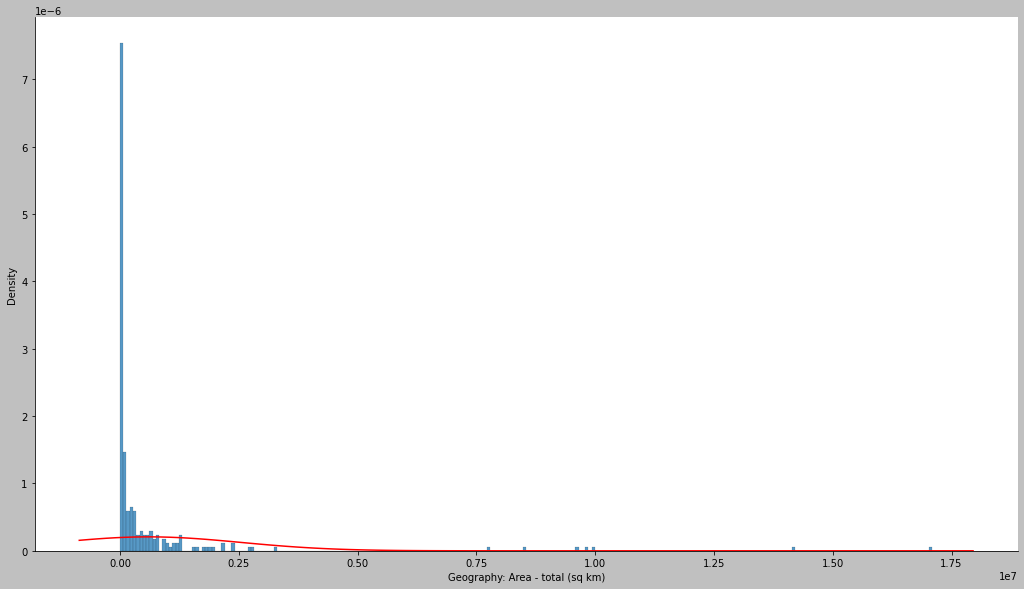

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Geography: Area - total


,ctry_i,ctry_s,zScore,value,orVal
183,191,Russia,8.560,17098242.000,"17,098,242 sq km"
7,7,Antarctica,7.056,14200000.000,14.2 million sq km
41,42,Canada,4.869,9984670.000,"9,984,670 sq km"
235,243,United States,4.790,9833517.000,"9,833,517 sq km"
46,47,China,4.667,9596960.000,"9,596,960 sq km"
30,31,Brazil,4.106,8515770.000,"8,515,770 sq km"
13,13,Australia,3.704,7741220.000,"7,741,220 sq km"


In [5]:
# identify outliers with z-score standardization
pDense = dUtls.showPDens  # display probability distrib. with fit
zThresh = dUtls.getZThreshDF  # For showing observations above z-score

# visual Gaussian-fit check 
pDense( 'Geography: Area - total' )

# checking with z-score 
zThresh( 'Geography: Area - total', 2.5 )

By contrast, though still with a minimum-skewed distribution: in **Military and 
Security: Military expenditures**, North Korea's dramatic, isolated prominence 
at the "most militarized" end turns out to be the result of extraction error. 
They do still remain the world leader for the feature, at between 20-25% of GDP.

PROBABILITY DENSITY FOR:
Military and Security: Military expenditures


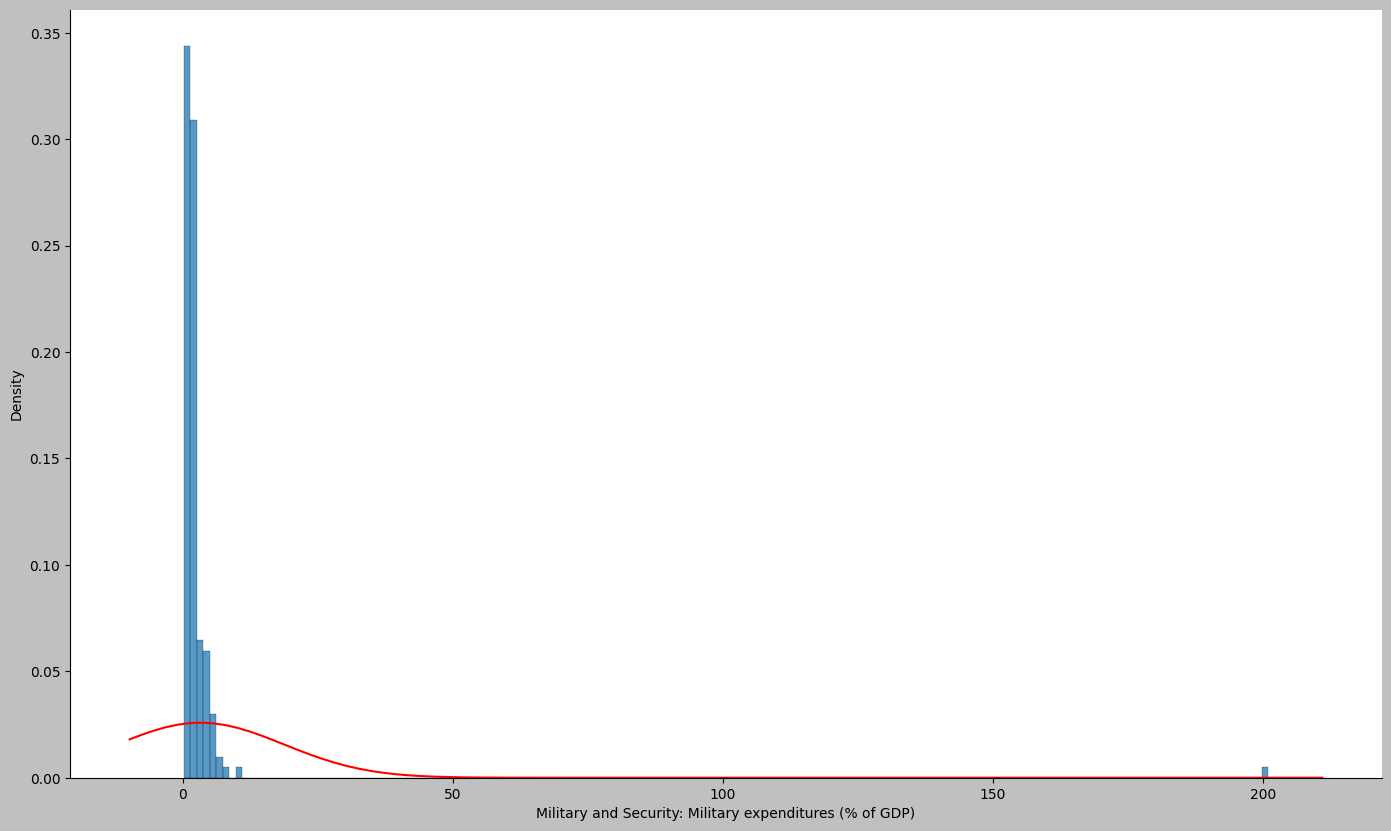

"between 2010 and 2019, military expenditures accounted for an estimated 20-25% of North Korea's GDP annually"


In [6]:
ft = 'Military and Security: Military expenditures'
pDense( ft )
zDF = zThresh( ft, 0.228, ret=True )
print( f"\"{[ b for a, b in zDF.orVal.items() ][ 0 ]}\"" )


In [7]:
# provide local access to required module data tools
getCorrs_T = dUtls.getCTDct  # get all feature correlations at threshold
reportDifs = dUtls.reportDiffs  # show non-null differences in correlation pair
showMax = dUtls.showMaxima  # barplot for countries by feature-maxima/minima 
pltSctr = dUtls.plotScttr  # scatterplot distribution for feature pair
getRank = dUtls.getRank  # return country's rank for value for feature
getVal = dUtls.getVal  # return val for country for feature

***
### Exploration, Analysis and Visualisation
Reporting is broadly categorized into discussions of correlations and maxima in:
1. People and Society
2. Coal, Energy and Pollution
3. Economy
4. Geography and Environment

#### *A NOTE ON FEATURE MAXIMA (HIGHEST / LOWEST SCORING COUNTRIES)*
The highest and lowest values for features compiled by the CIA's World Factbook 
provide a convenient global view on important aspects of humanity and the 
environment. Some caution is necessary before interpreting these summaries 
due to conflagration of time period (the CIA resource mixes the latest 
reporting year, which can vary by decade or more).

#### *A NOTE ON CORRELATIONS AND SCATTERPLOTS*

In [8]:
# generate correlation significance between all features 
dUtls.getCorDct()  # generate feature master correl. dict

- [221002_165423324122] Compiled 19900 correlations


**Perfect correlations** (of significance -1 or 1) are rarely informative, in 
that they identify effectively identical, or duplicate, features. For this 
reason, they can be useful for reducing unnecessary dimensionality in large 
datasets.

In [9]:
# drop perfect correlations (duplicates)
dUtls.dropDupCorrs()

- [221002_165423342556] Dropping duplicate features
    corr=1.0
    ftrX='Geography: Land use - agricultural land'
    ftrY='Environment: Land use - agricultural land'

    corr=1.0
    ftrX='Geography: Land use - other'
    ftrY='Environment: Land use - other'

    corr=1.0
    ftrX='Environment: Urbanization - urban population'
    ftrY='People and Society: Urbanization - urban population'

    corr=1.0
    ftrX='Environment: Urbanization - rate of urbanization'
    ftrY='People and Society: Urbanization - rate of urbanization'

    corr=1.0
    ftrX='Economy: Unemployment, youth ages 15-24 - total'
    ftrY='People and Society: Unemployment, youth ages 15-24 - total'

    corr=1.0
    ftrX='Economy: Unemployment, youth ages 15-24 - male'
    ftrY='People and Society: Unemployment, youth ages 15-24 - male'

    corr=1.0
    ftrX='Economy: Unemployment, youth ages 15-24 - female'
    ftrY='People and Society: Unemployment, youth ages 15-24 - female'



**Strong correlations** will tend to be more self-evident (for example, "Total 
area" being near-perfectly correlated to "Total land", with some noise caused 
by variable water-area), but still provide an empirical, observational basis 
for testing assumptions. 

**Scatter plots** are useful for identifying or demonstrating where a clear 
pattern, like a linear correlation, is present, and also for an alternative 
view on observations made with different techniques.

**Some near-perfect correlations** (including some duplicate features where
the data is differentiated only by null values):

In [10]:
# Examine near-perfect threshold (likely still duplicates or self-evident)
dUtls.reportDiffs( getCorrs_T( 0.998 ) )


CORRELATION FOR FEAT-PAIR [10, 76]
IN THRESH +-=[ 0.998-inf ] 
CORR: 0.9999999999999999
BASE: Geography: Land use - forest
COMP: Environment: Land use - forest
[10, 76]: DIFFERENCES ALL NaN


CORRELATION FOR FEAT-PAIR [1, 2]
IN THRESH +-=[ 0.998-inf ] 
CORR: 0.9995056827871487
BASE: Geography: Area - total
COMP: Geography: Area - land
160 Non-NaN diffs for [1, 2]. First 3:


,Geography: Area - total,Geography: Area - land
Albania,28748.000,27398.000
Argentina,2780400.000,2736690.000
Armenia,29743.000,28203.000



CORRELATION FOR FEAT-PAIR [41, 42]
IN THRESH +-=[ 0.998-inf ] 
CORR: 0.9984123657153035
BASE: People and Society: Infant mortality rate - total
COMP: People and Society: Infant mortality rate - male
225 Non-NaN diffs for [41, 42]. First 3:


,People and Society: Infant mortality rate - total,People and Society: Infant mortality rate - male
Albania,10.820,11.850
Algeria,19.720,21.770
American Samoa,10.060,12.140


***
#### *PEOPLE AND SOCIETY*

Continuing with correlation strength for a moment:

- **Strong negative correlations** (for features X and Y, as X approaches 
maximum, Y clearly tends towards minimum): in the Factbook data, at least one 
of each pair of features that has a negative correlations above a minimal 0.5 
significance threshold is either **Birth Rate** or **Rate of Urbanization.** 
Excluding these two features, the strongest negative correlation has a 
signicance score of -0.45.

In [11]:
dUtls.reportStrongNeg( -0.5 )

All of 37 negative correlations stronger than sigThresh=-0.5 
    were for feature pairs that included at least one of 
    excluded=[': Birth rate', ': Urbanization']


- **Including** these two features, many correlations are fairly **self-
evident**. For example, the strongest, at **-0.81**:

Feats: [ Energy: Electricity access - electrification - total population ]
       [ People and Society: Birth rate ]


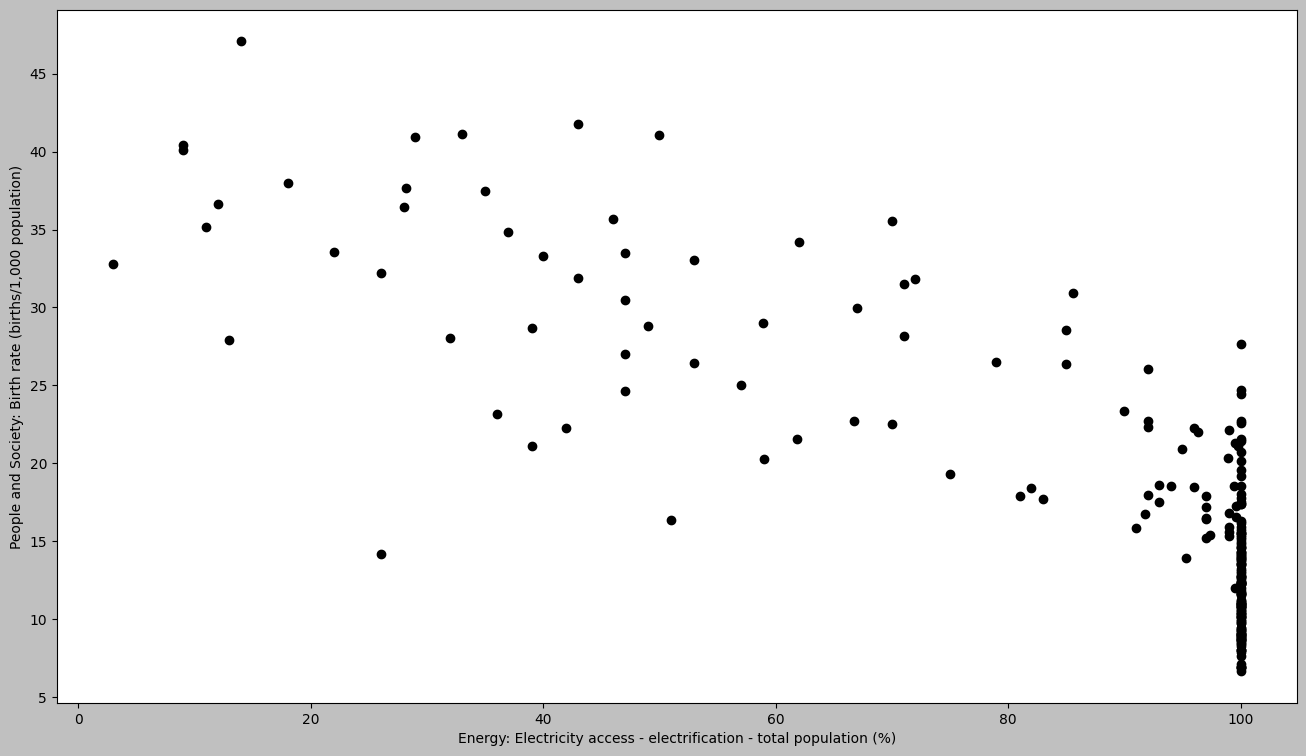

In [12]:
pltSctr( [ 'Energy: Electricity access - electrification - total population',
    'People and Society: Birth rate' ] )

- It stands that with a higher birth rate, the percentage of the population 
(including the newborn) that does not have access to an existing electrical 
connection, particularly where the cost of connections are more prohibitive for 
the average income, should rise proportionally.

<hr style="height:2px;background-color:gray">

- One that takes a little more unpacking is a correlation of significance -0.73
between **Rate of urbanization** and **Literacy (total population)**.

Feats: [ People and Society: Literacy - total population ]
       [ People and Society: Urbanization - rate of urbanization ]


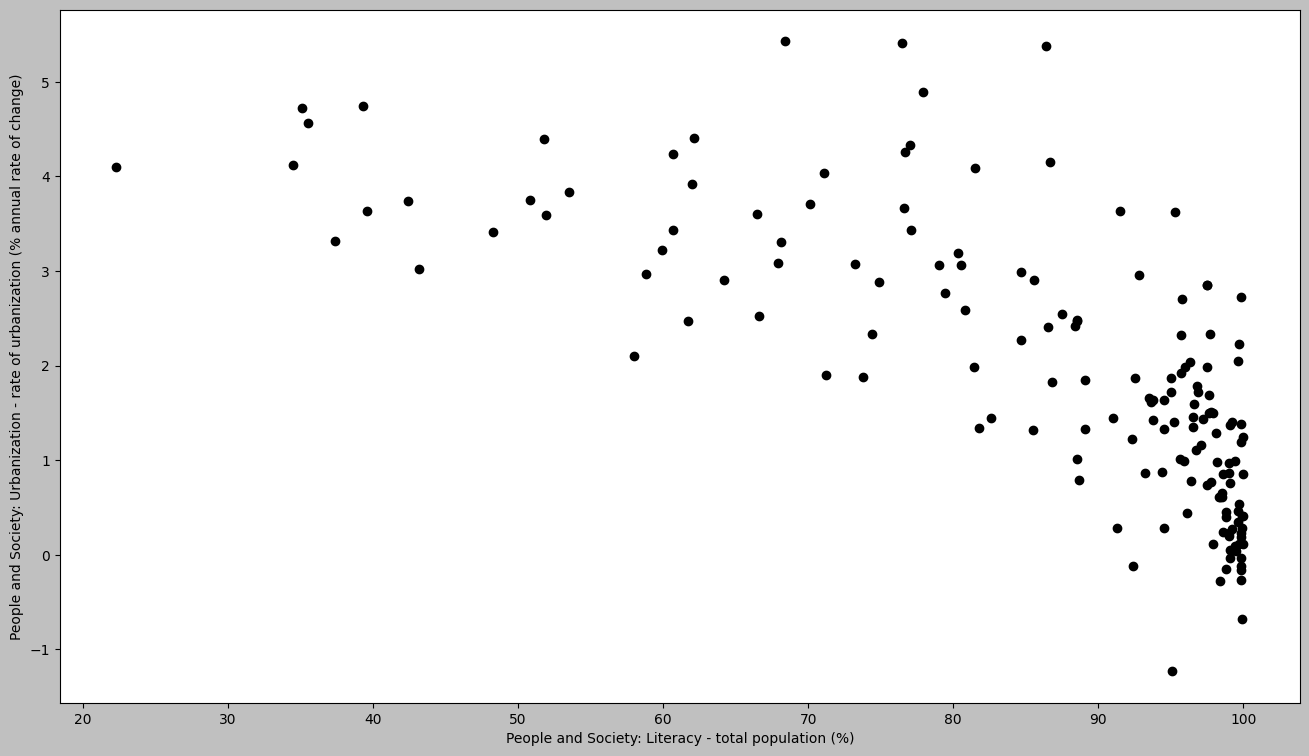

In [13]:
pltSctr( [
    'People and Society: Literacy - total population',
    'People and Society: Urbanization - rate of urbanization' ],
    uns=[ "%", "% annual rate of change" ] )


- According to this correlation, the higher the rate of people moving to live in
urban areas, the lower the average literacy of the population. A suitable 
explanation might be that the rate of urbanization is an indicator - or even the 
same as - a rate of industrialization (the industrial centralization of 
societies); in other words, that literacy is less prevalent where sudden, large 
increases in industrial development are possible. 

<hr style="height:2px;background-color:gray">

- There's a neat curvilinear distribution between **percent population over 64**
and percent **under 15**, showing a clear negative relationship.
- Likewise, in a positive trend, the strong association of **higher birthrate**
with **bigger proportion of 15-24yo's** rapidly decreases after the birthrate 
hits around 20%; after this point, that segment is relatively stable for higher 
birthrates.

Feats: [ People and Society: Age structure - 65 years and over ]
       [ People and Society: Age structure - 0-14 years ]


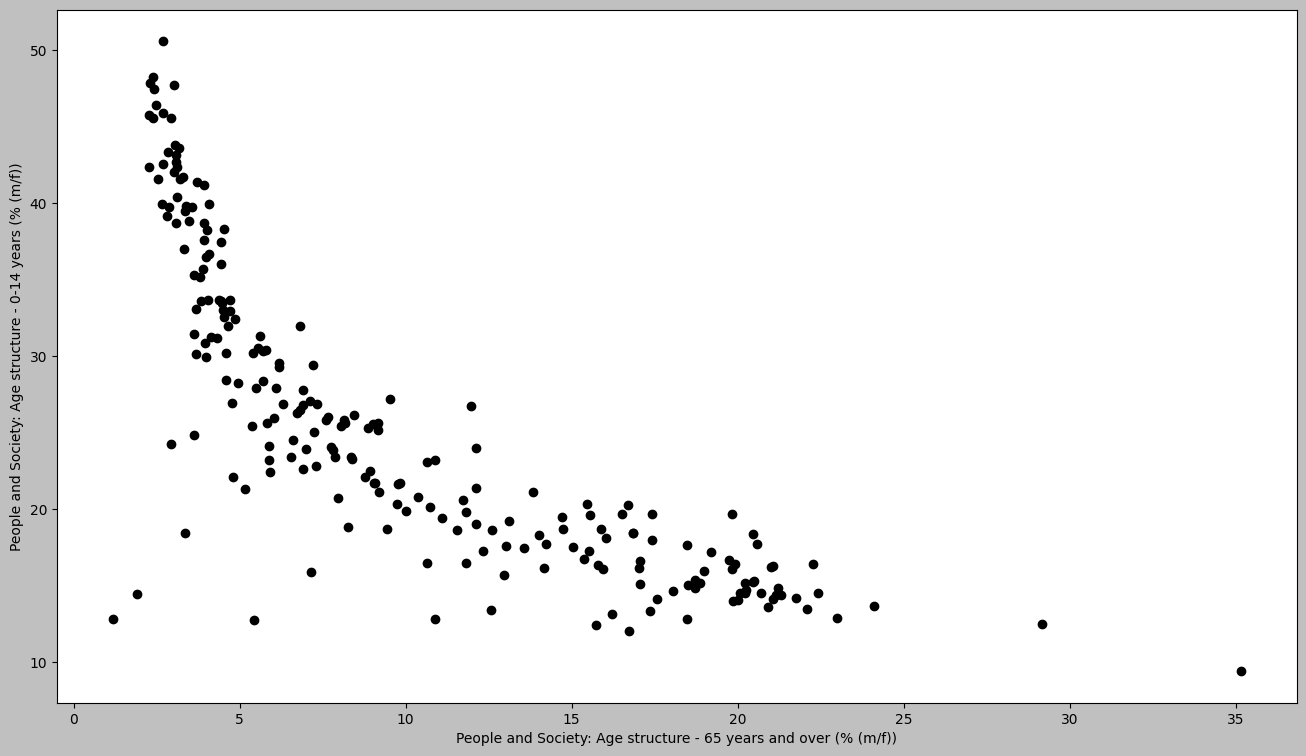

Feats: [ People and Society: Birth rate ]
       [ People and Society: Age structure - 15-24 years ]


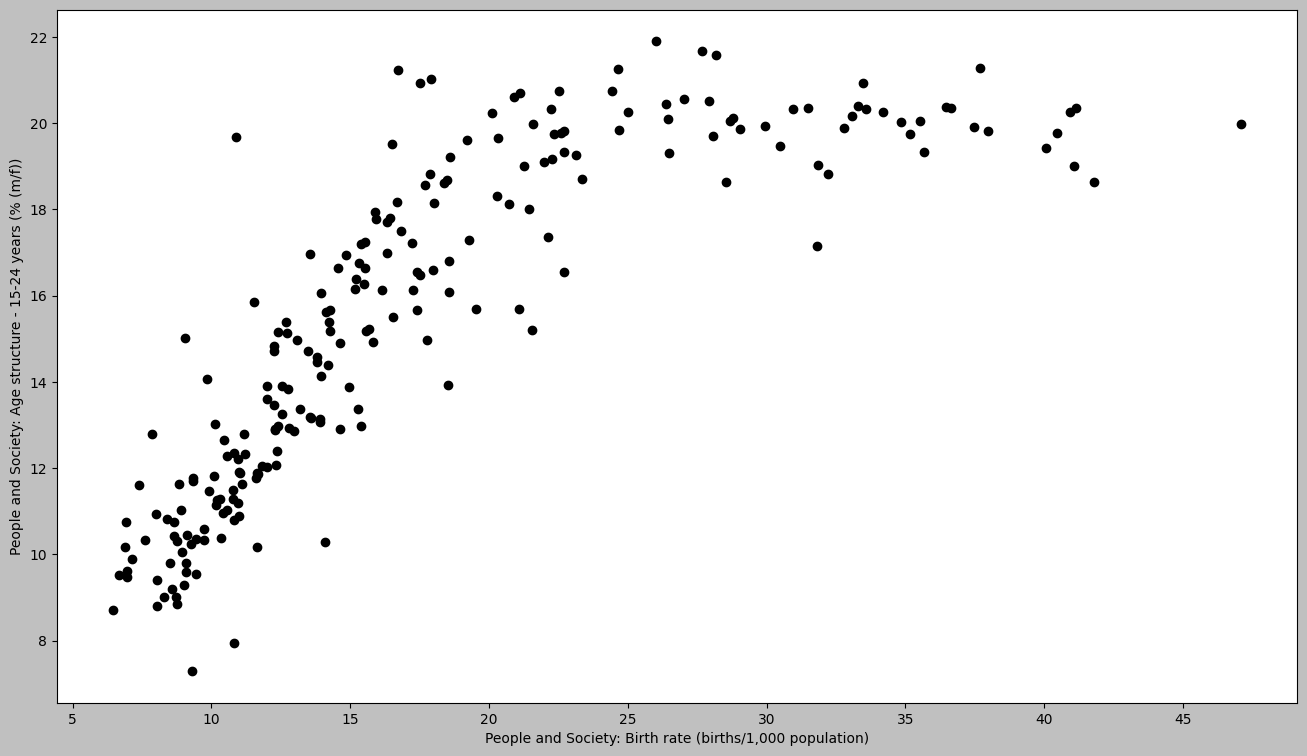

In [14]:
pltSctr( [
    'People and Society: Age structure - 65 years and over',
    'People and Society: Age structure - 0-14 years' ] )

pltSctr( [
    'People and Society: Birth rate',
    'People and Society: Age structure - 15-24 years' ] )

<hr style="height:2px;background-color:gray">

- Gulf countries occupy the distribution of **sex ratio weighting** where it 
tends toward men - startlingly so for Qatar & the Unite Arab Emirates.
Note we can see strong support for 
[Fisher's principle](https://en.wikipedia.org/wiki/Fisher%27s_principle): sex 
ratio is leptokurtic, closely gathered around the one-to-one ratio.

Z_SCORES OUTSIDE >+/<-[ 0.8 ] for non-NaNs in:
People and Society: Sex ratio - total population


,ctry_i,ctry_s,zScore,value,orVal
163,189,Qatar,12.365,3.360,3.36 male(s)/female (2022 est.)
212,241,United Arab Emirates,6.327,2.210,2.21 male(s)/female (2022 est.)
14,17,Bahrain,2.704,1.520,1.52 male(s)/female (2022 est.)
110,129,Kuwait,1.916,1.370,1.37 male(s)/female (2022 est.)
177,203,Saudi Arabia,1.549,1.300,1.3 male(s)/female (2022 est.)
152,175,Oman,0.866,1.170,1.17 male(s)/female (2022 est.)
54,65,Djibouti,-0.919,0.830,0.83 male(s)/female (2022 est.)


PROBABILITY DENSITY FOR:
People and Society: Sex ratio - total population


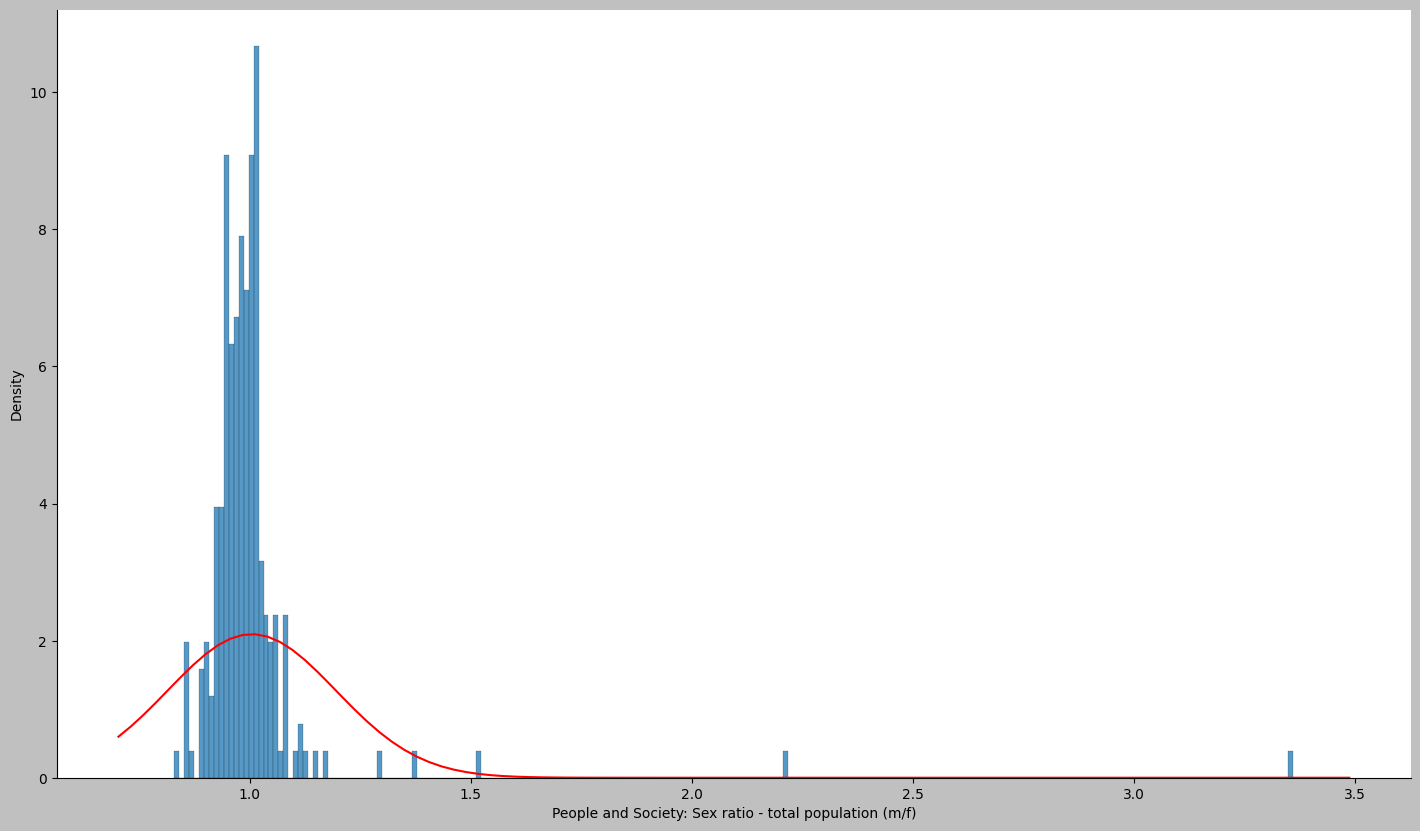

In [15]:
zThresh( ft := 'People and Society: Sex ratio - total population', 0.8 )
pDense( ft )

- At the same time, both have (by good measure) the **highest proportion of
total population that is 25-54 years old**. 

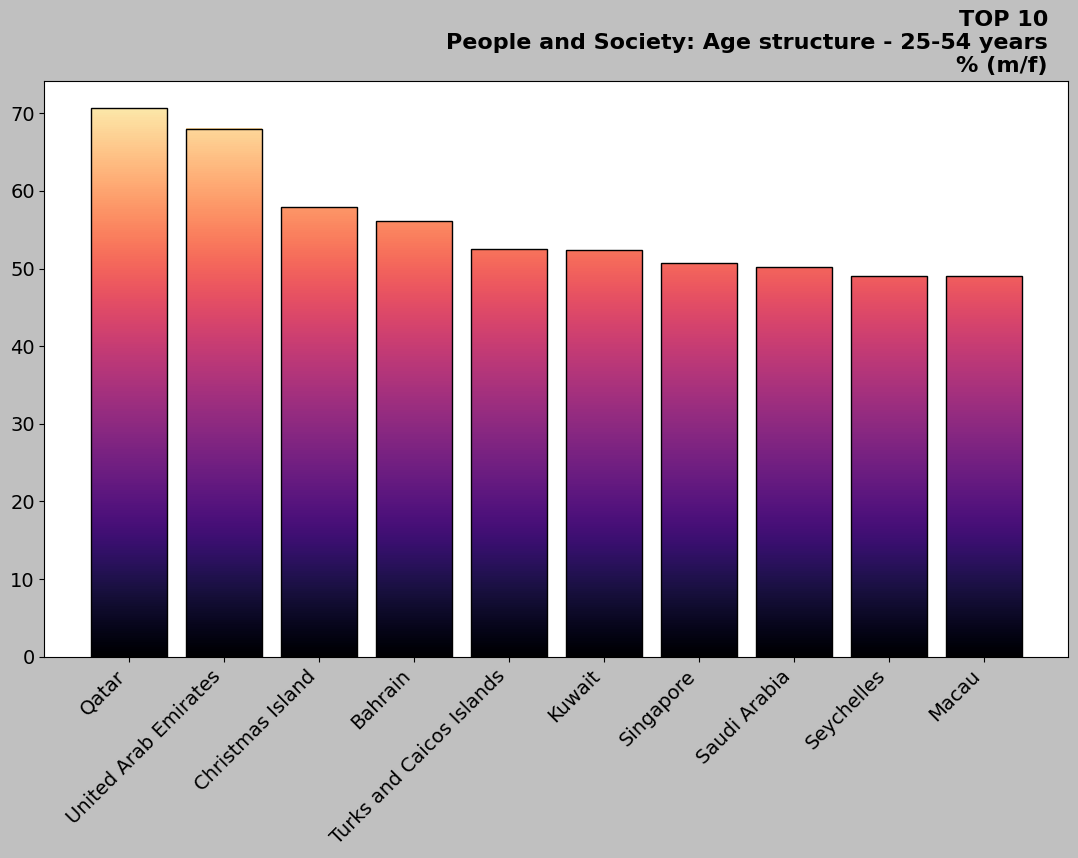

In [47]:
showMax( 'People and Society: Age structure - 25-54 years' )

- So, in other words, Qatar and the UAE have a particularly large and masculine 
working-age population.

<hr style="height:2px;background-color:gray">

- in Palau, North Korea, and particularly East European countries, there 
are **more than twice as many old women as old men**. In other terms, men are 
dying considerably earlier than women in these countries.

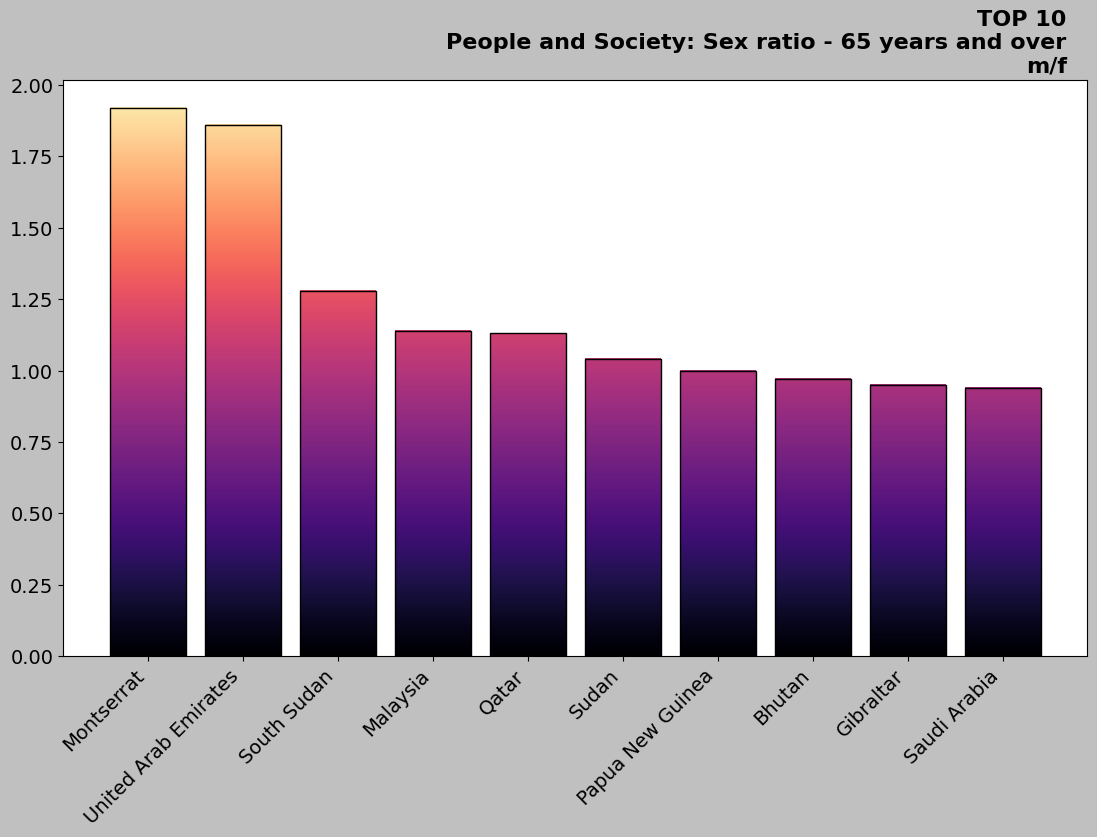

In [17]:
showMax( 'People and Society: Sex ratio - 65 years and over', asc=True )

<hr style="height:2px;background-color:gray">

- Some surprise might arise from the data on **Health Expenditure**: despite 
highest costs for *individuals* in the OECD (see 
[here](https://en.wikipedia.org/wiki/Health_care_prices_in_the_United_States) 
for example), the US Government is spending more - as a percentage of GDP - on 
health than almost any other nation (Tuvalu excepted.)

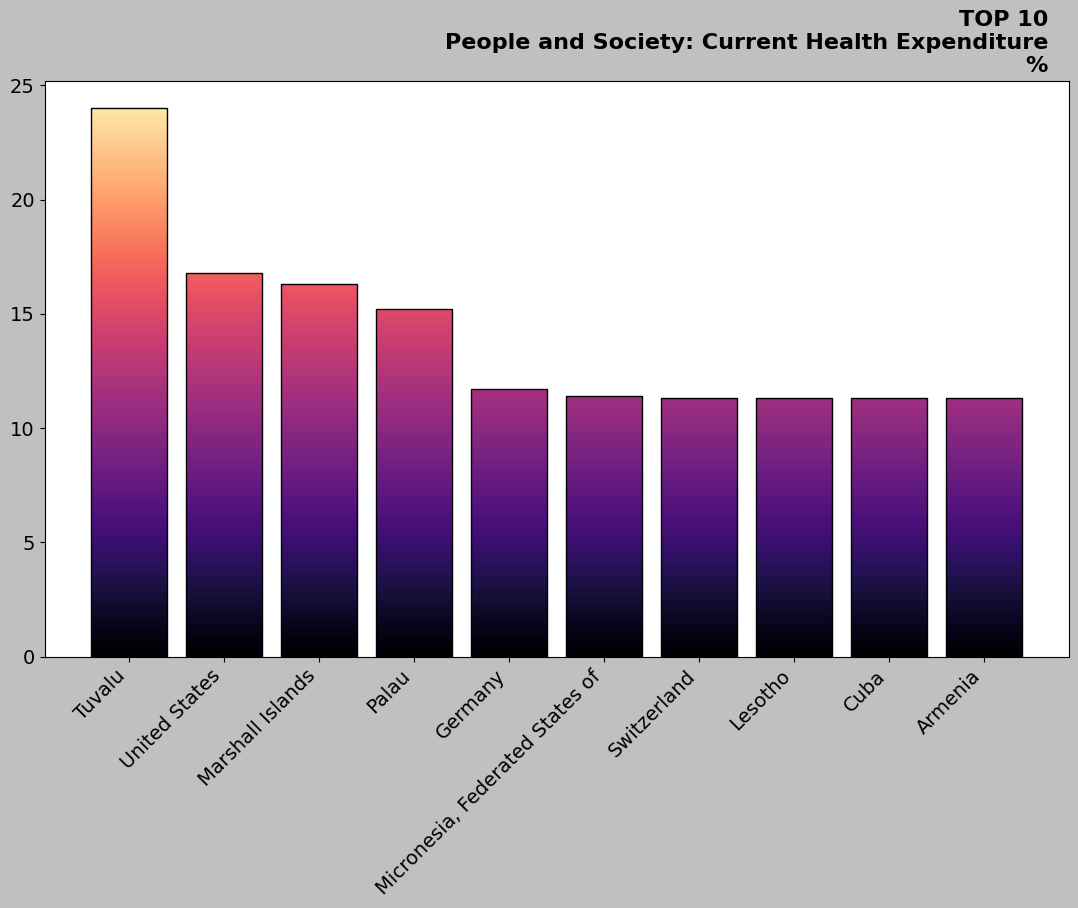

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
People and Society: Current Health Expenditure


,ctry_i,ctry_s,zScore,value,orVal
174,238,Tuvalu,5.874,24.000,24% (2019)
179,243,United States,3.452,16.800,16.8% (2019)
105,147,Marshall Islands,3.284,16.300,16.3% (2019)
129,177,Palau,2.914,15.200,15.2% (2019)


In [18]:
showMax( ft := 'People and Society: Current Health Expenditure' )
zThresh( ft, 2.5 )

<hr style="height:2px;background-color:gray">

- Interesting to see Monaco leading the top-ten for **Physician 
density** while at the same time trailing in the very bottom for **Health 
expenditure**. Citizens are privately funding most of a large, expert-intensive 
healthcare system. 
- There are surprisingly **zero nations from the Anglosphere** in the top-ten 
for physician density. More data would be needed to probe a following question, 
going back to the example of US government and private healthcare costs: 
with fewer physicians per individual, is there a measurable failure of 
preventative care that might have been afforded by the access and familiary 
that community-embedded physicians could provide?

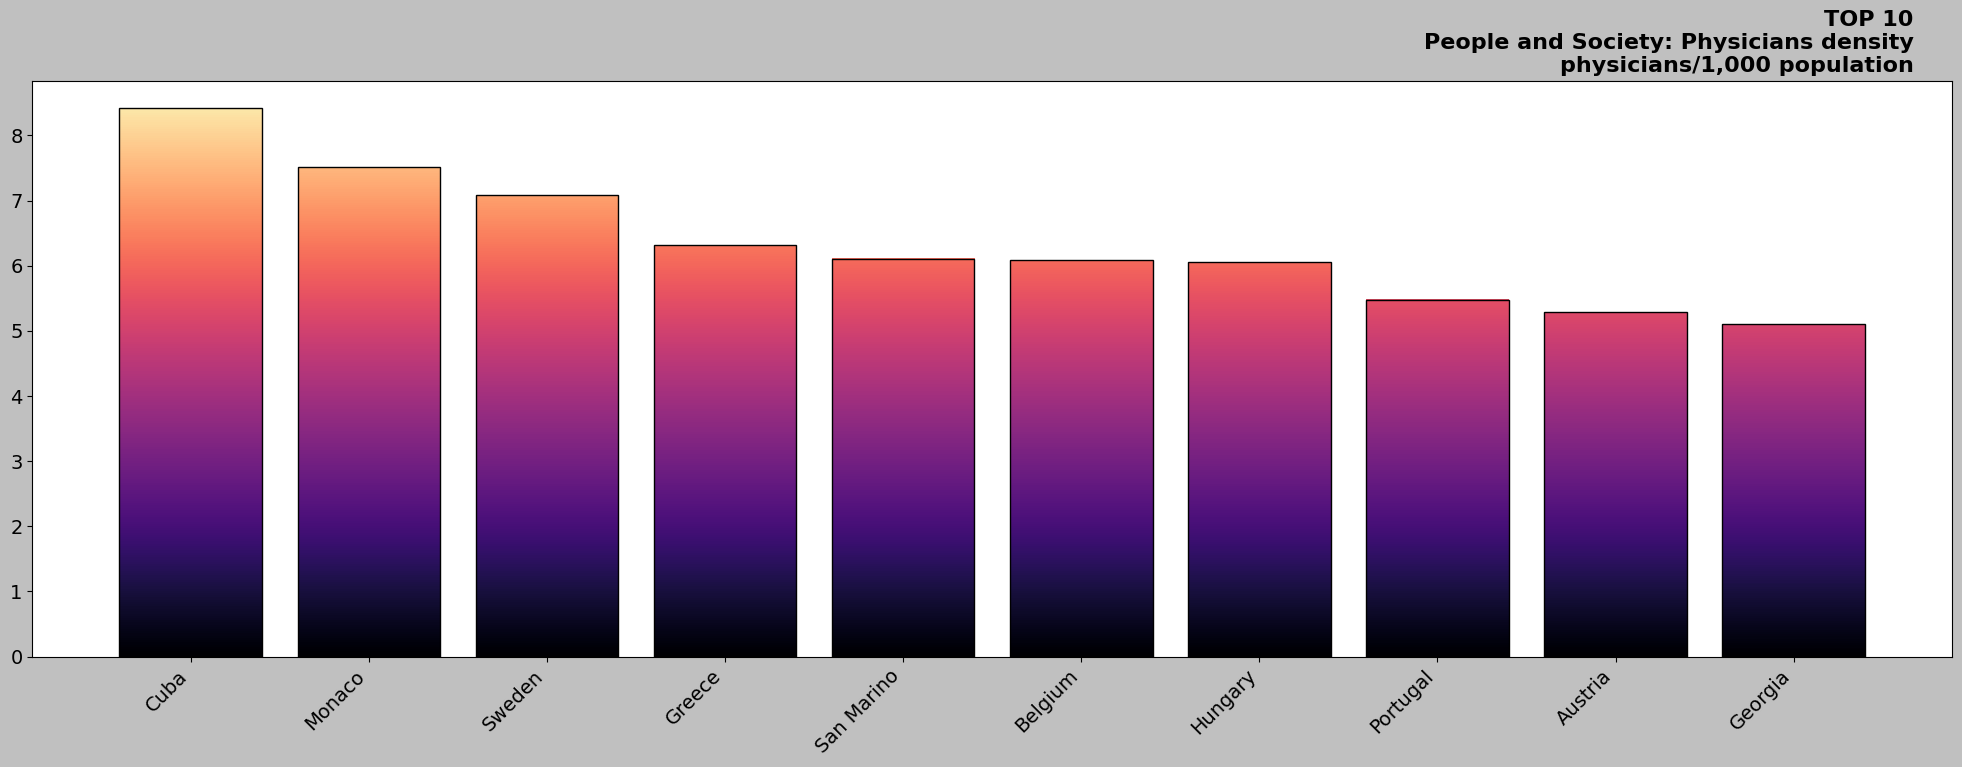

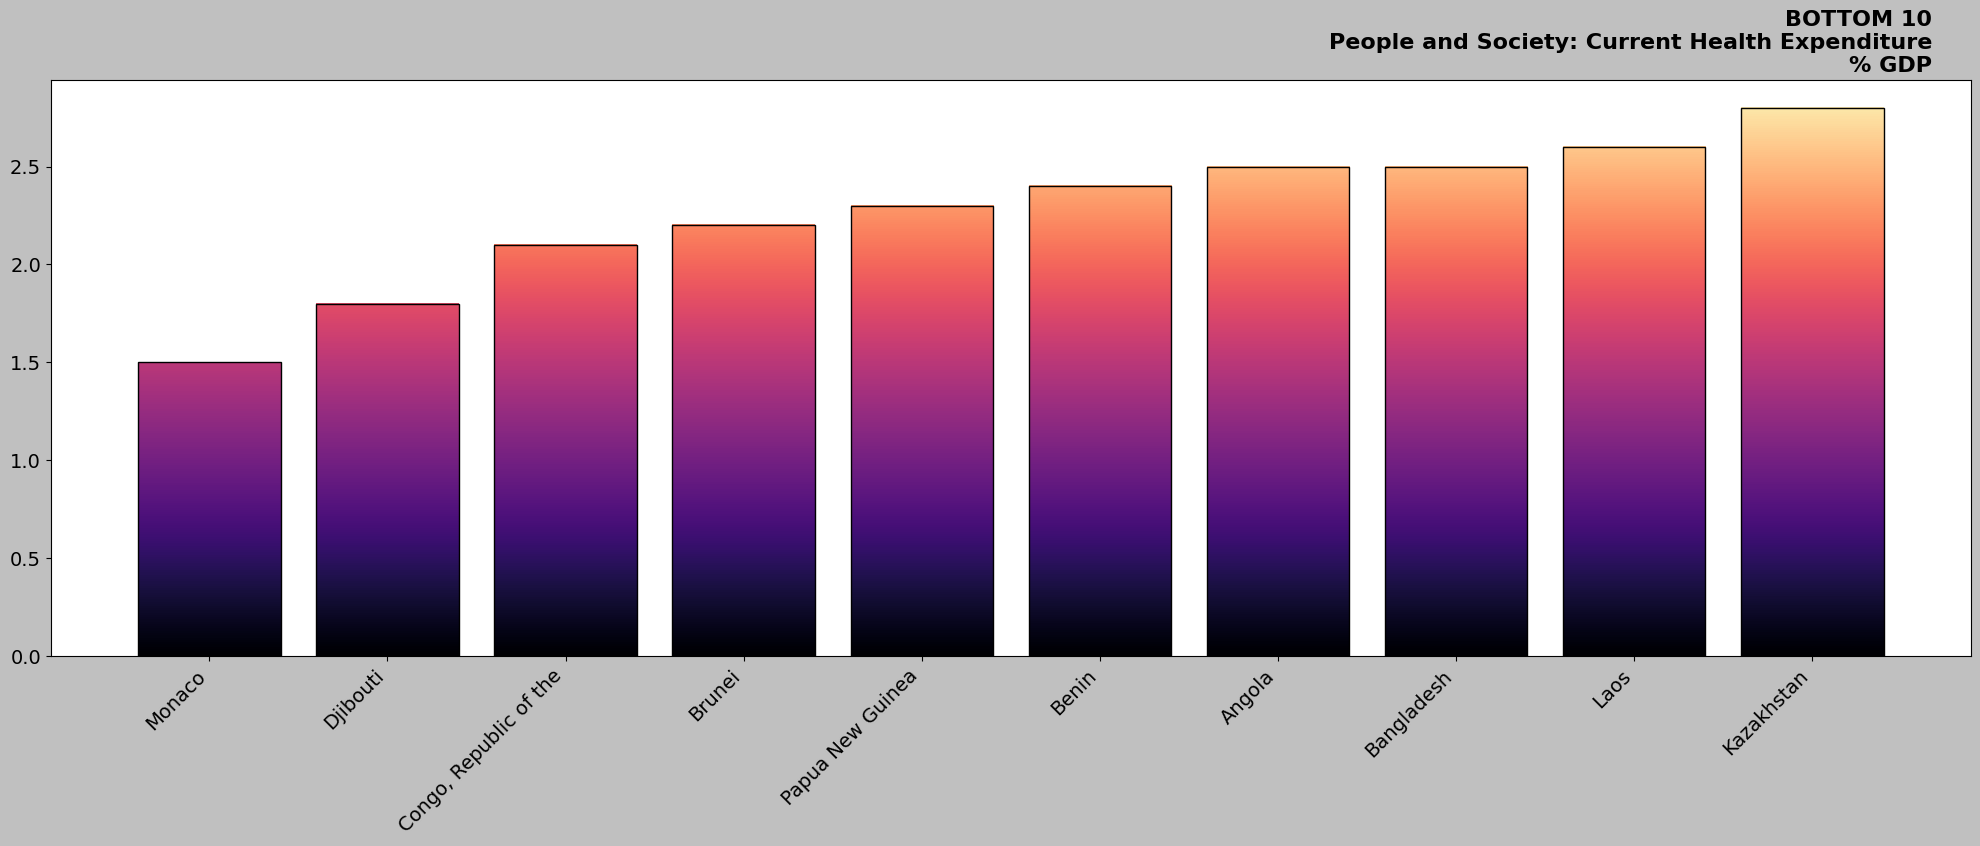

In [19]:
showMax( 'People and Society: Physicians density', short=True )
showMax( 'People and Society: Current Health Expenditure', asc=True,
    short=True, unit="% GDP" )

<hr style="height:2px;background-color:gray">

- Southern African nations exclusively form the top 10 for **percent of 
population living with HIV/AIDs**:

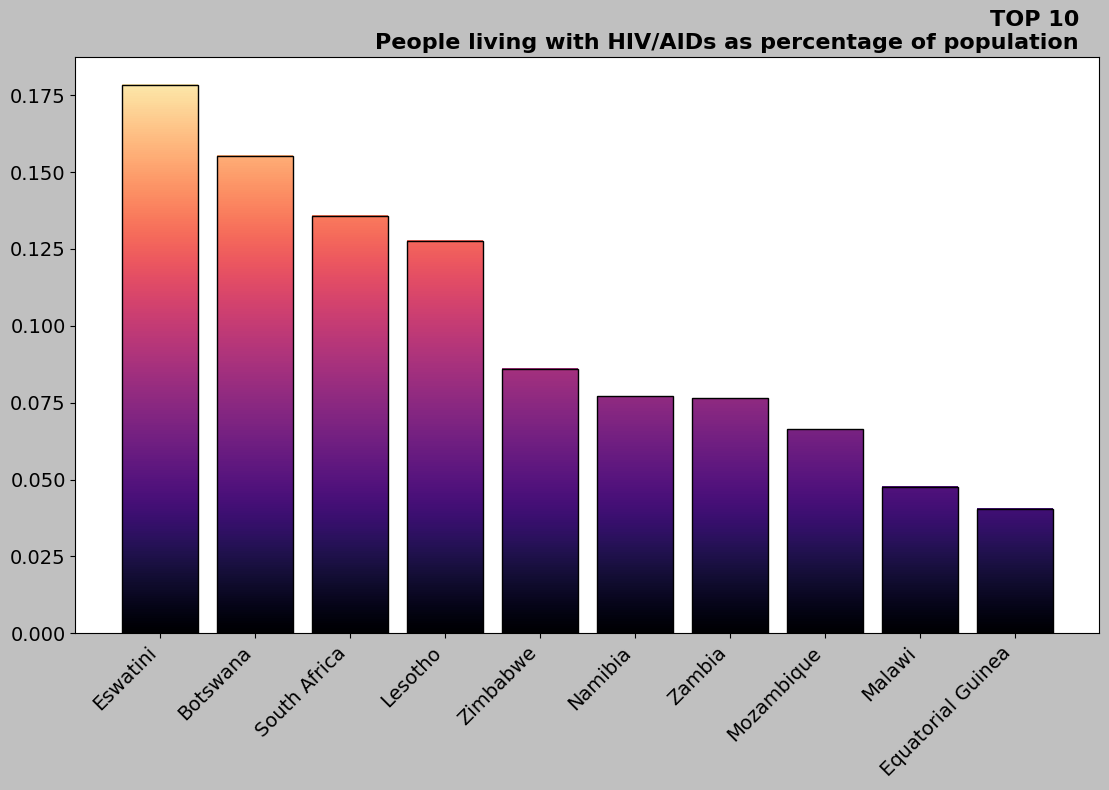

In [20]:
nData.DF[
    (ft := 'People living with HIV/AIDs as percentage of population') ] = (
    nData.DF[ 'People and Society: HIV/AIDS - people living with HIV/AIDS' ] /
    nData.DF[ 'People and Society: Population' ])

showMax( ft, unit="_" )

- What, then, is the **lowest prevalence** in the Southern Africa high-HIV/AIDS 
region?

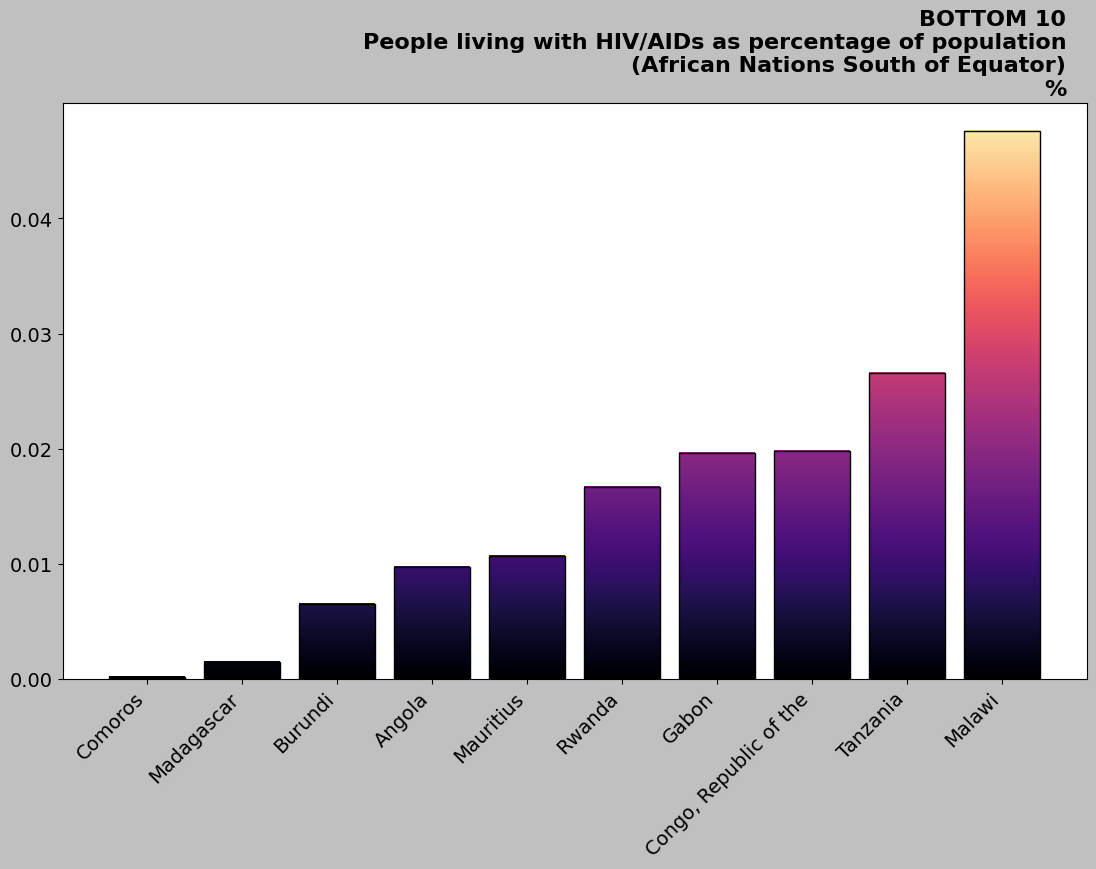

In [21]:
sthEquatAfrica = nData.OR[
    (nData.OR[ "Geography: Map references" ] == "Africa") &
    (nData.OR[ "Geography: Geographic coordinates" ].str.contains( "S" )) ]

showMax( 'People living with HIV/AIDs as percentage of population', asc=True,
    mask=nData.DF[ 'Country' ].isin( sthEquatAfrica.Country.to_list() ),
    sub="African Nations South of Equator", unit="%" )

- For mainland countries, Angola - being large, and close to the HIV/AIDs 
epicentre, appears to have some form of strongly inhibiting factor.
A look at recent history identifies a cause for the low prevalence: civil war. 

> The 27-year civil war in Angola, lasting from 1975 until 2002, kept the spread 
> of HIV to a minimum due to large parts of the country being inaccessible to 
> people infected with the virus. During the civil war, individuals from 
> neighboring countries such as Zambia, Botswana, and Zimbabwe (all countries 
> with high prevalence rates of HIV) were also not allowed to come into the 
> country, which played a significant role in controlling the spread of HIV.
> [(source: Wikipedia)](https://en.wikipedia.org/wiki/HIV/AIDS_in_Angola#History)

<hr style="height:2px;background-color:gray">

- **Gender and Tobacco usage**: When limited to females, top-smoking European 
nations remain in the t10, while the Asia-Pacific nations Burma, Kiribati, 
Timor Leste, PNG and Indonesia all disappear (the men are the smokers). 
- This pattern is strikingly reversed for Nauru (where nearly half the 
people smoke), where it is female smoking which places it at number one, with 
Nauru's male smoking at 21st place.


With value of [ 47.8 ], Nauru is ranked 21 for:
    'People and Society: Tobacco use - male'
    (total 256, ranked DESCENDING)


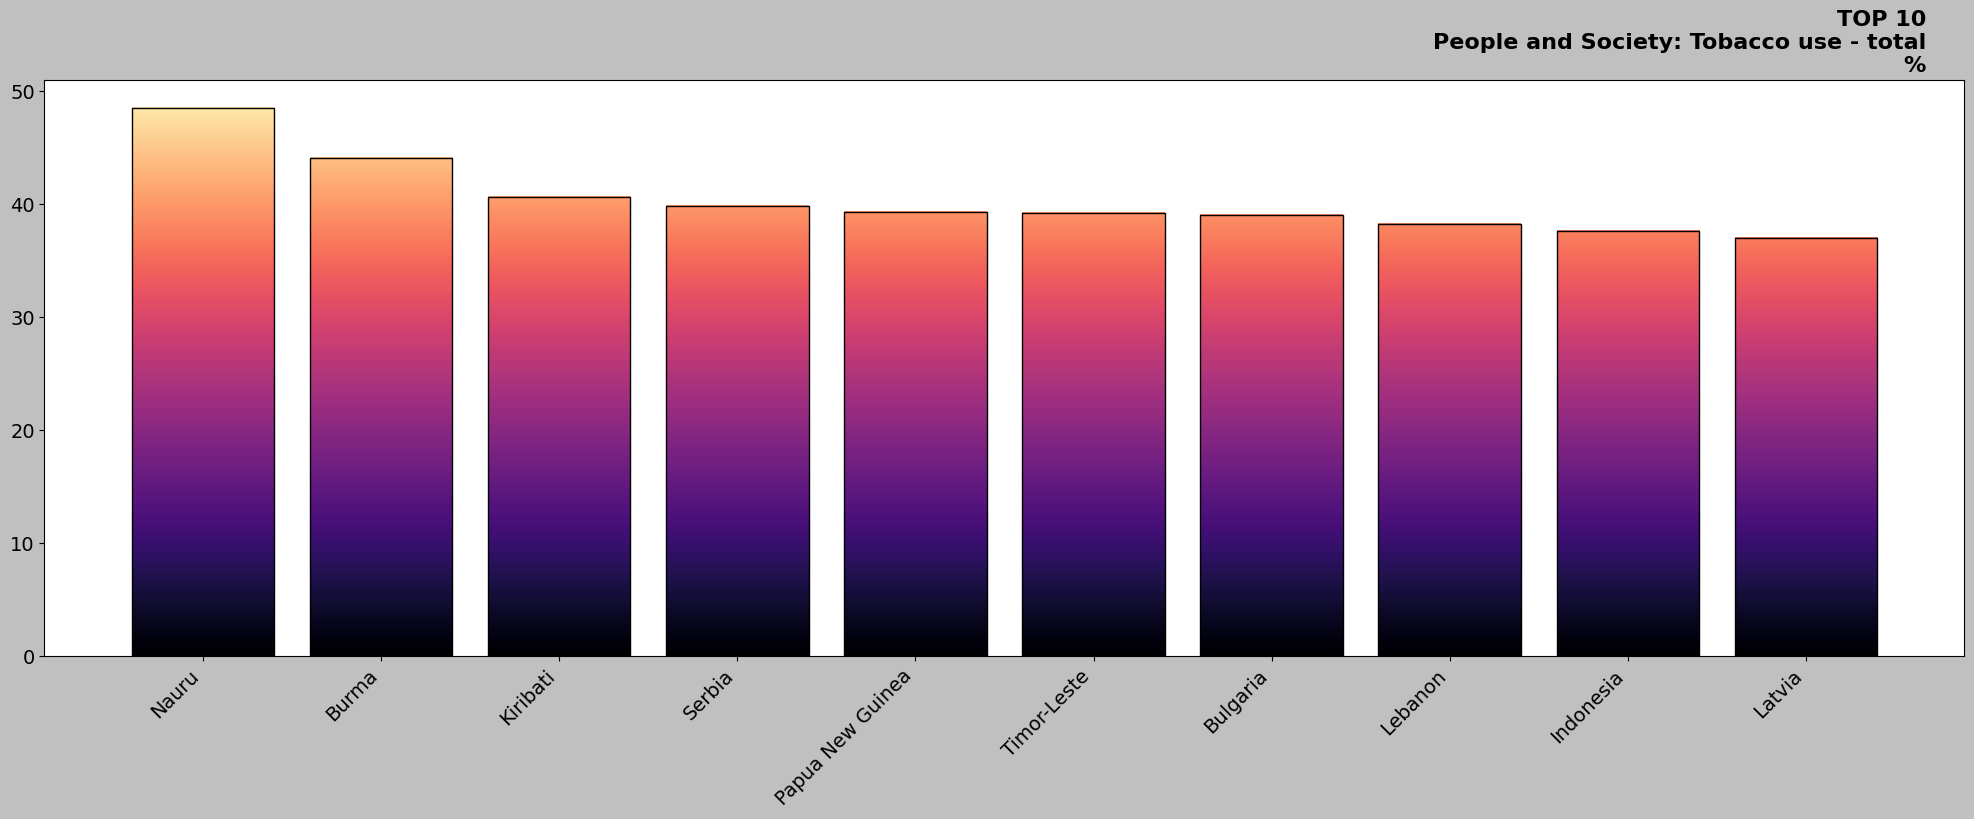

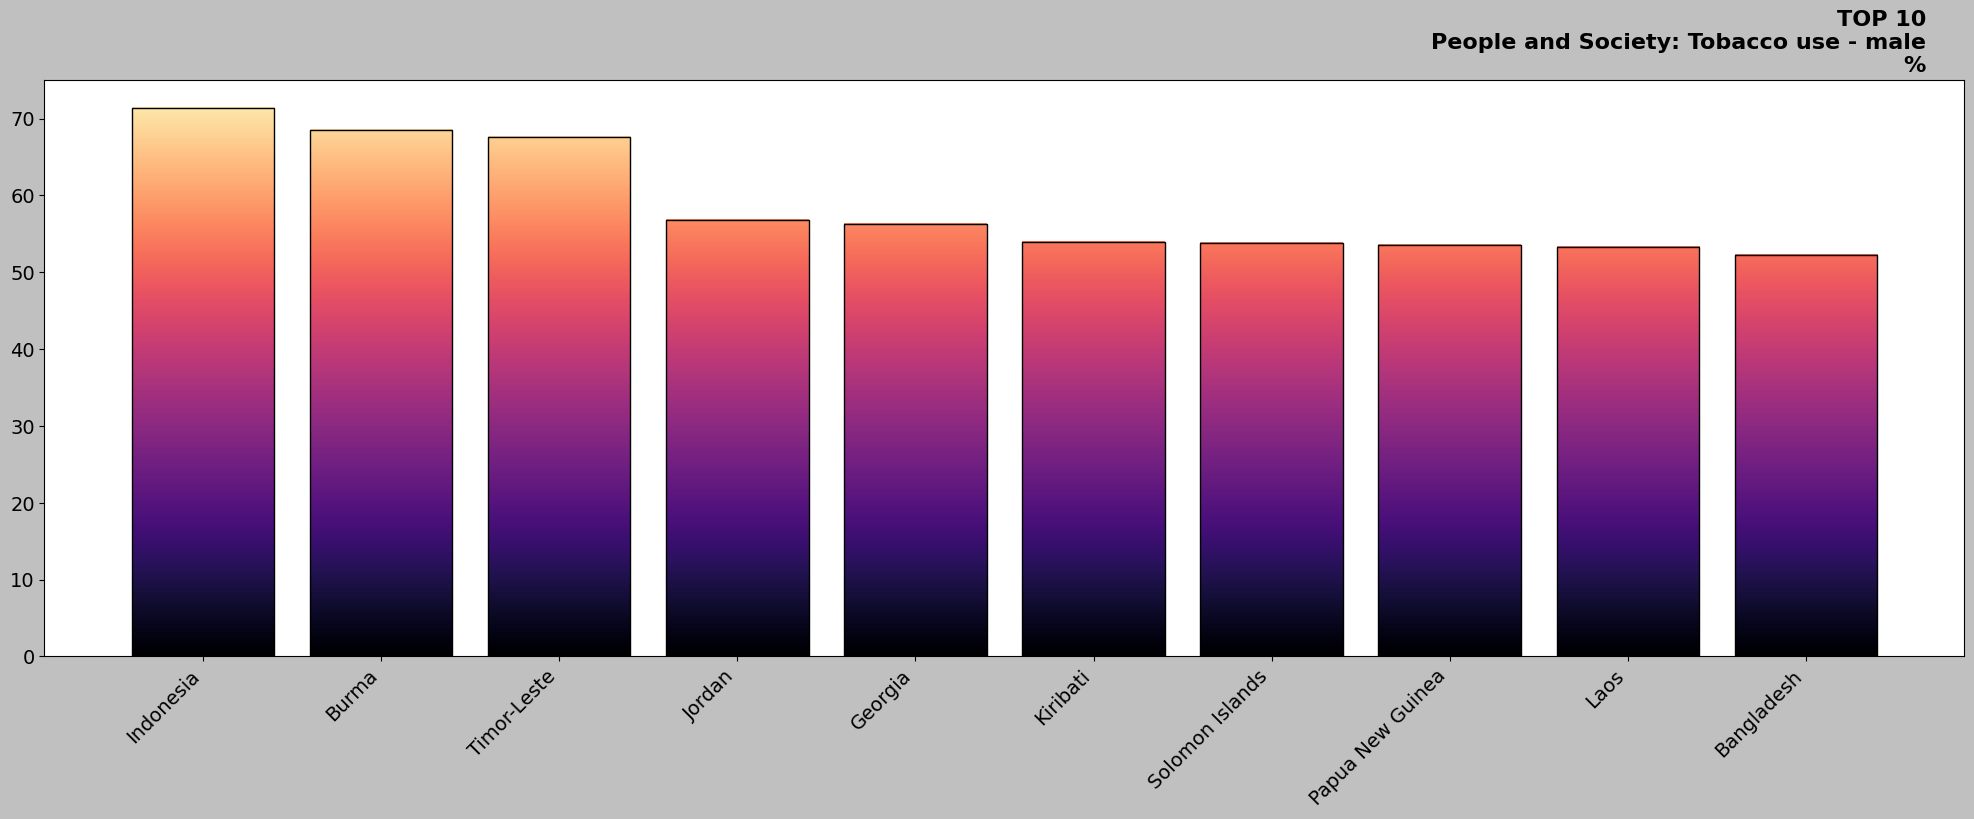

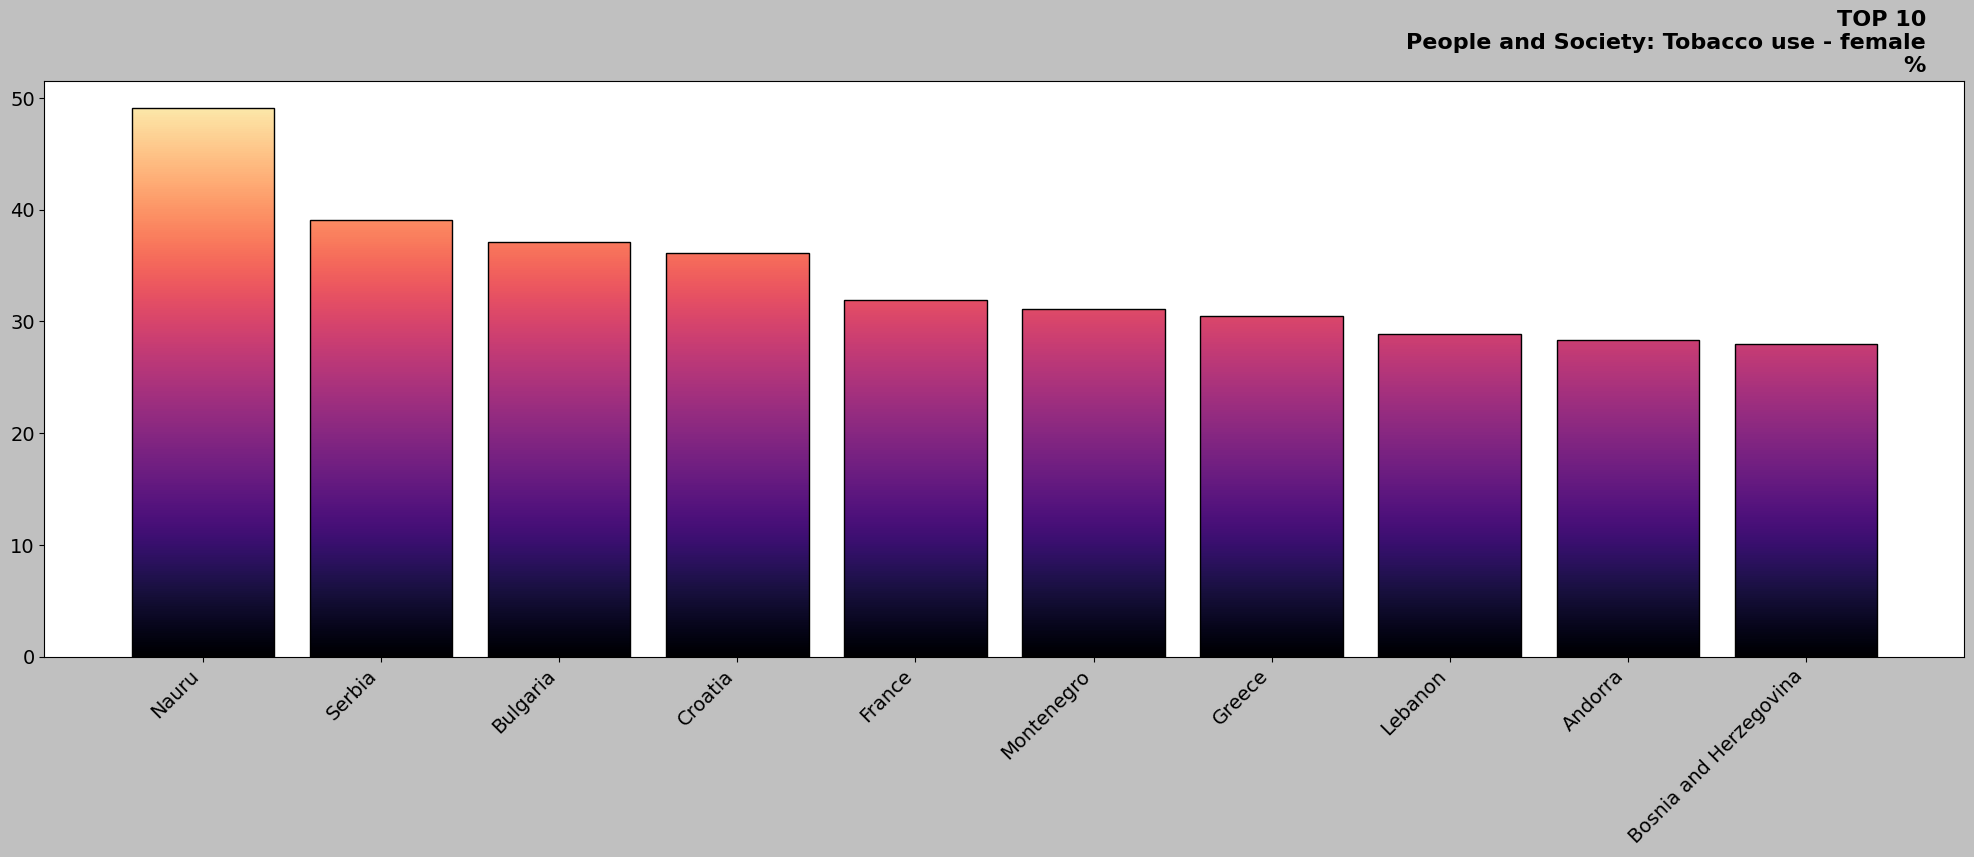

In [22]:
getRank( 'Nauru', 'People and Society: Tobacco use - male' )
showMax( 'People and Society: Tobacco use - total', short=True )
showMax( 'People and Society: Tobacco use - male', short=True )
showMax( 'People and Society: Tobacco use - female', short=True )

<hr style="height:2px;background-color:gray">

- **Generational weight disparity**: where is there the highest observations 
for both adult obesity prevalence and children 4 years and under who are 
underweight? </br> </br> These maxima are limited to nations reporting **above-
mean observations** for both features (total seven).

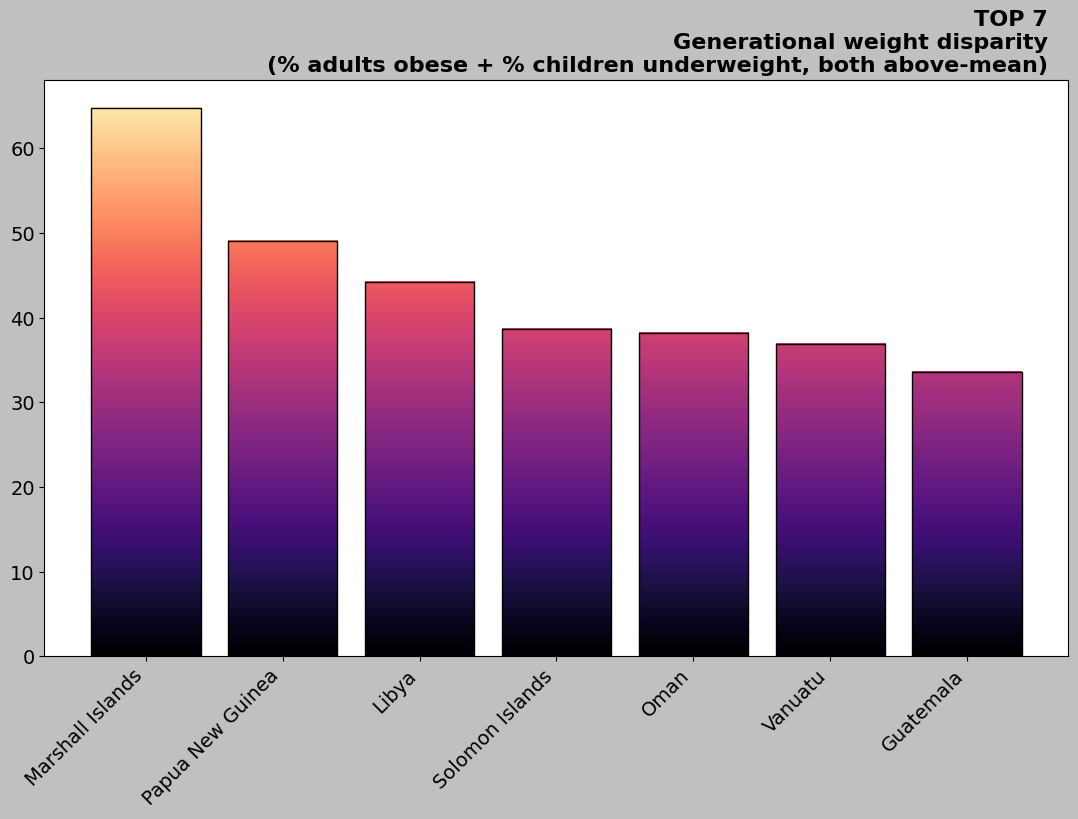

In [23]:
uFeat = 'People and Society: Children under the age of 5 years underweight'
oFeat = 'People and Society: Obesity - adult prevalence rate'

nData.DF[ 'Generational weight disparity' ] = (
    nData.DF[ uFeat ] + nData.DF[ oFeat ])

aboveMeans = [ country for country in nData.DF[ 'Country' ] if (
    nData.DF.loc[ nData.DF[ 'Country' ] == country, uFeat ].iloc[ 0 ]
    >= nData.DF[ uFeat ].mean() and
    nData.DF.loc[ nData.DF[ 'Country' ] == country, oFeat ].iloc[ 0 ]
    >= nData.DF[ oFeat ].mean()) ]

showMax( 'Generational weight disparity', unit="_",
    mask=nData.DF[ 'Country' ].isin( aboveMeans ),
    sub="% adults obese + % children underweight, both above-mean" )

<hr style="height:2px;background-color:gray">

- By a modest yet significant margin, Australia has the **longest times spent in 
school**, and the position **holds true for women** as much as men.

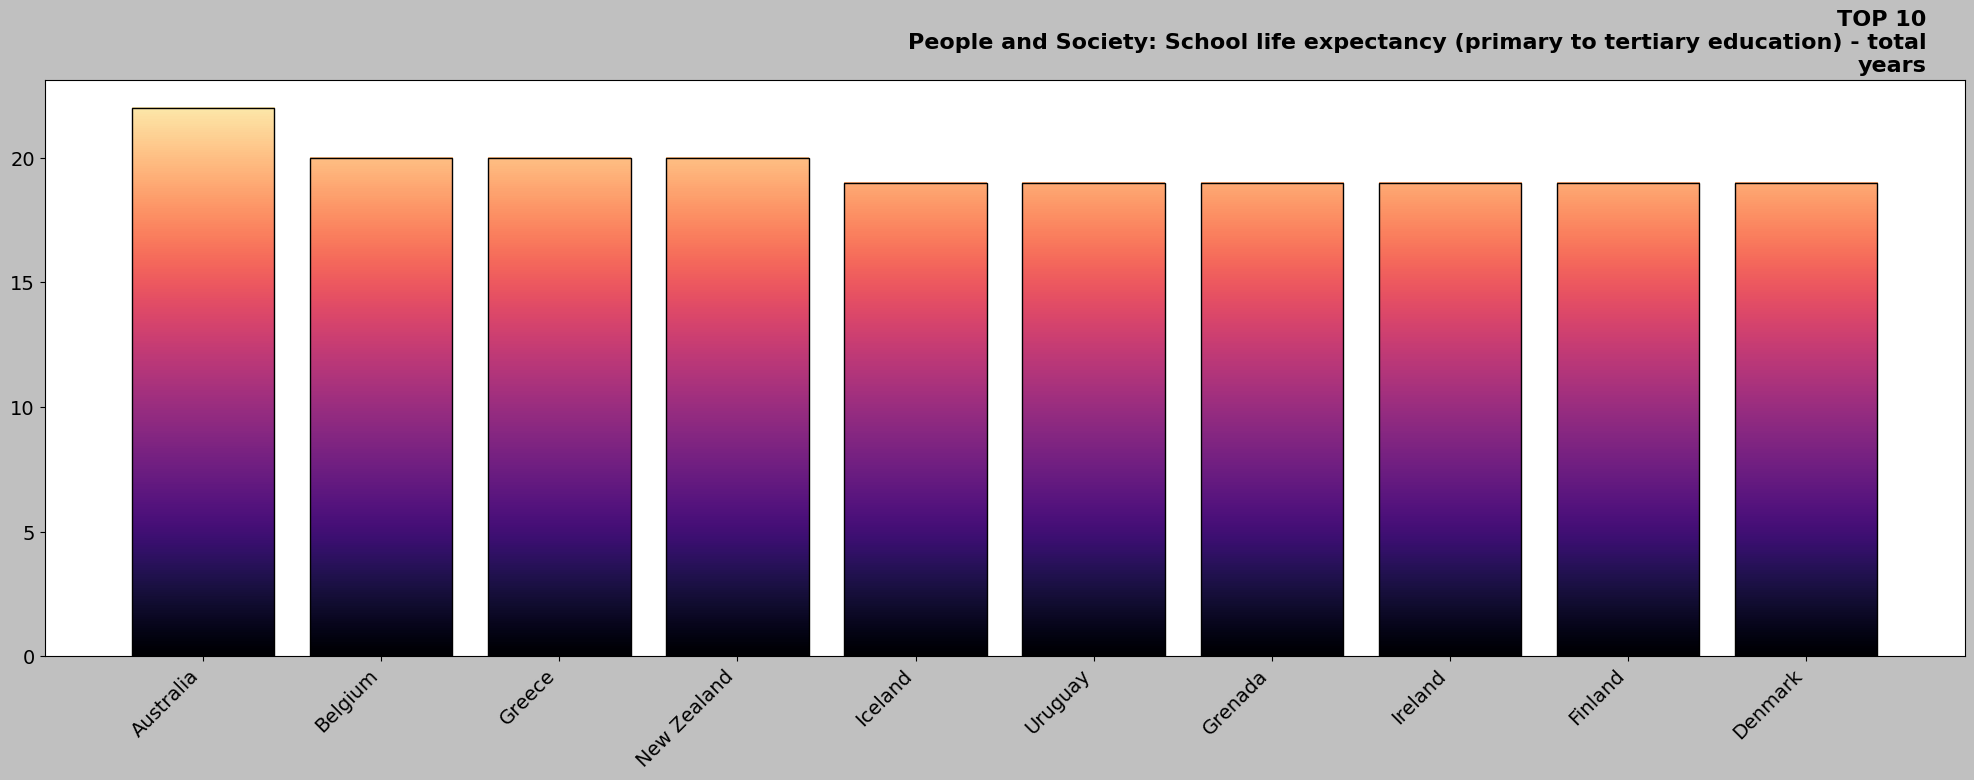

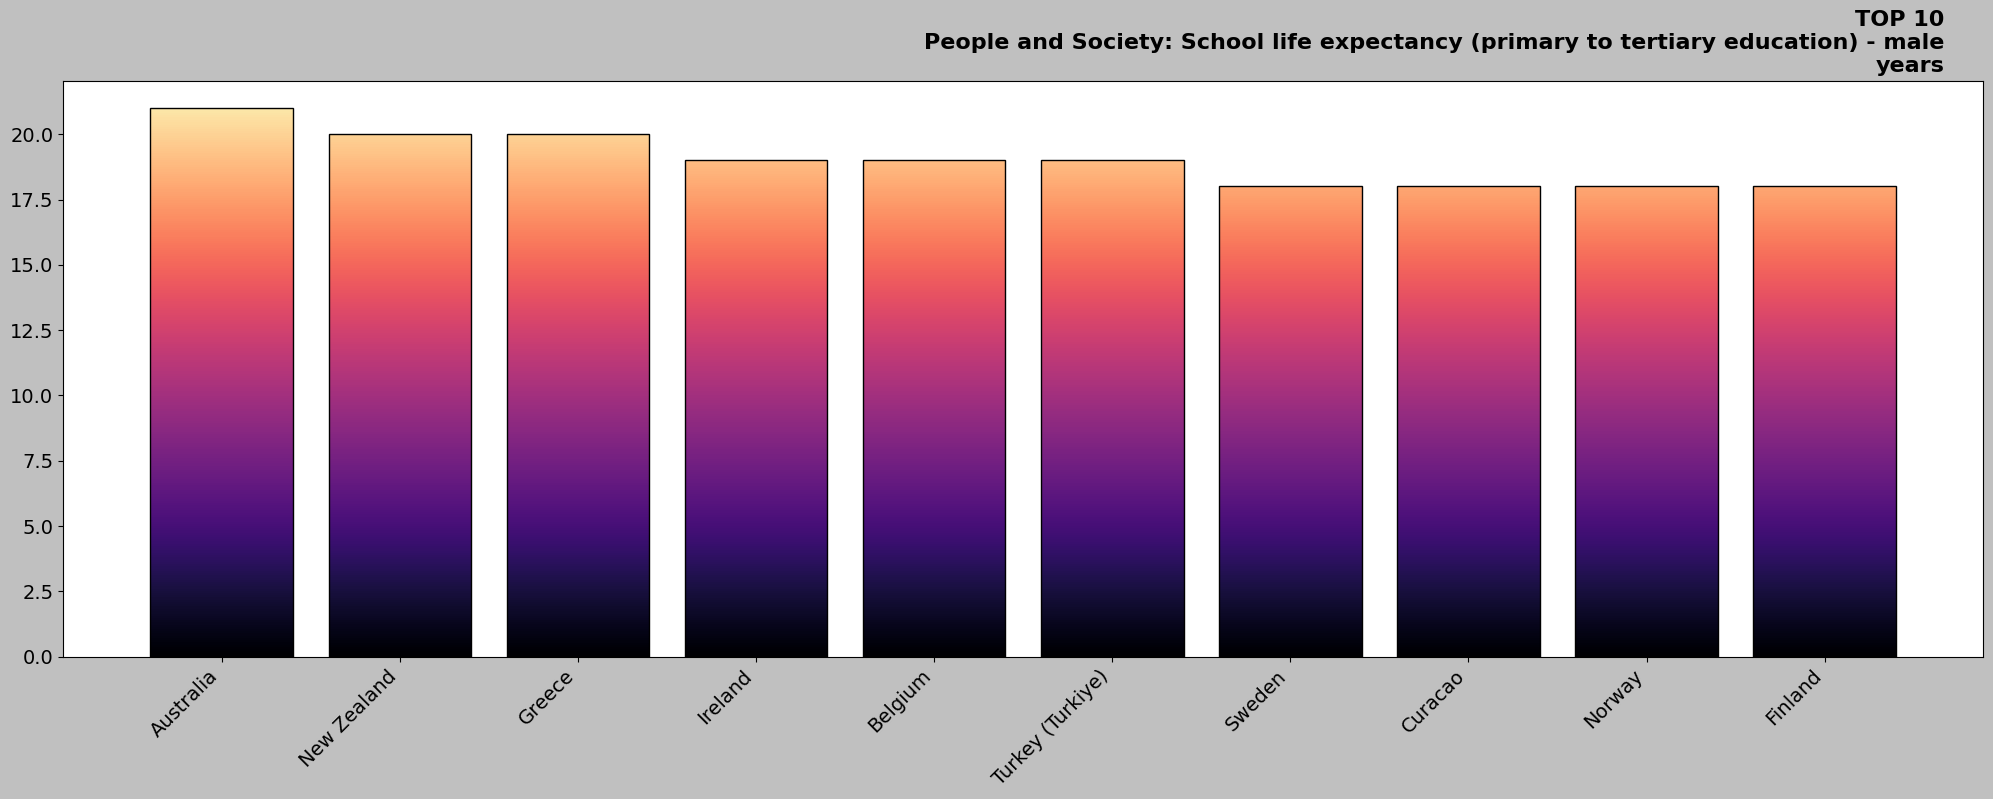

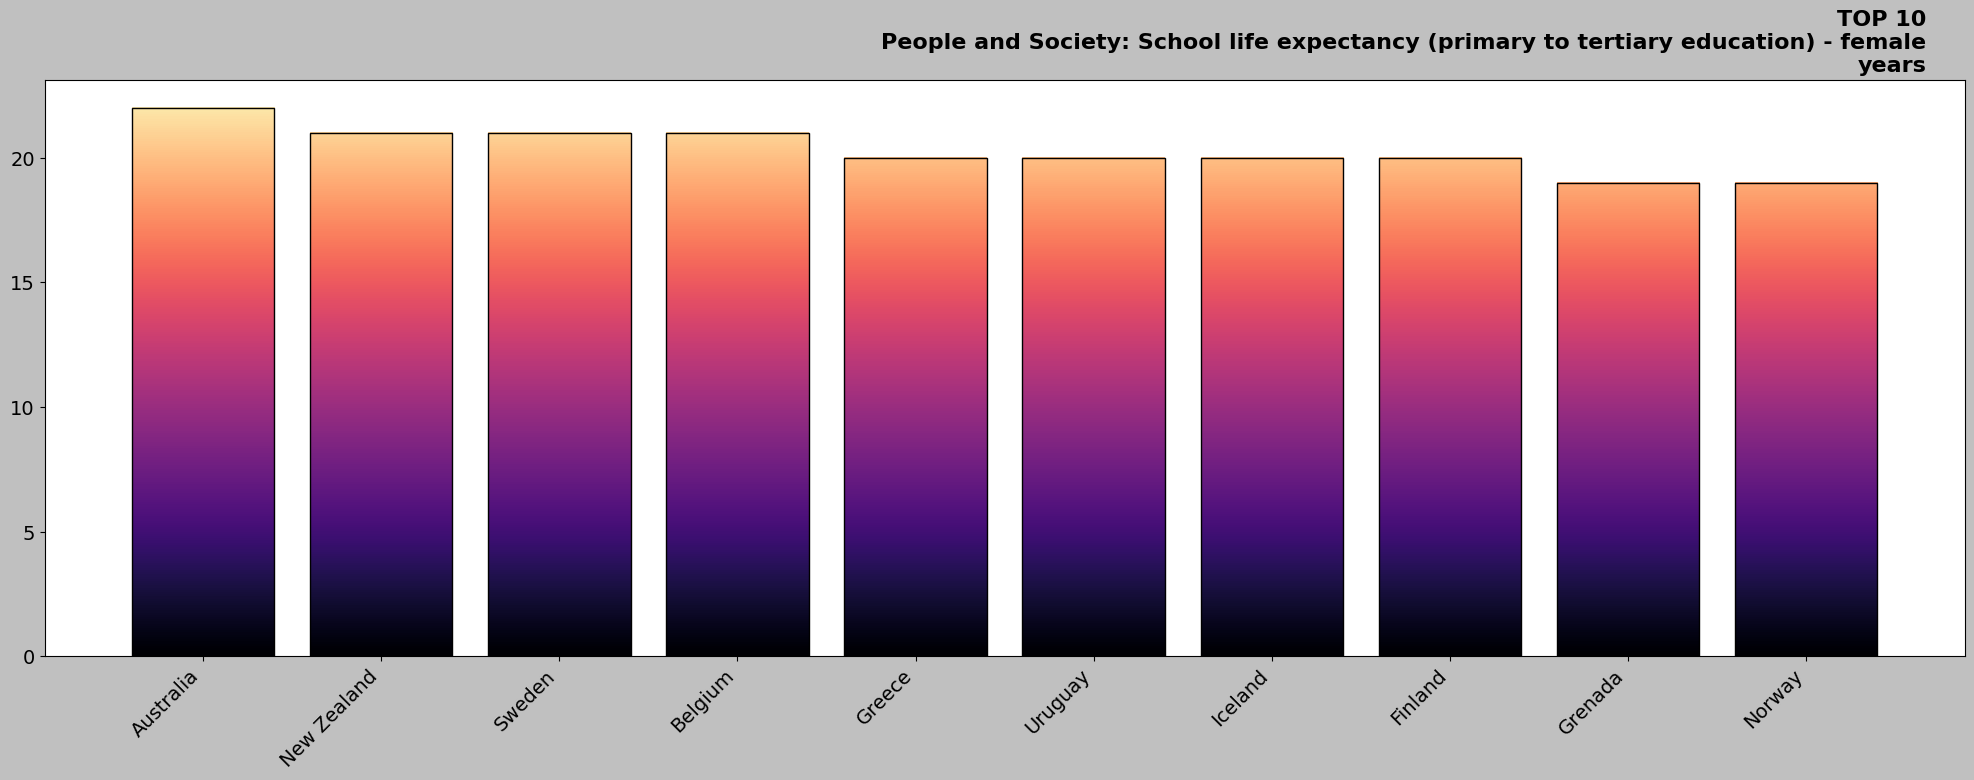

In [24]:
lifexpFt = ("People and Society: School life expectancy (primary to tertiary "
            "education) -")
showMax( f'{lifexpFt} total', short=True )
showMax( f'{lifexpFt} male', short=True )
showMax( f'{lifexpFt} female', short=True )


<hr style="height:2px;background-color:gray">

- **School-completion disparity in the sexes**: Liechtenstein stands out at 
least in terms of an implicit expectation of access to services, having one of 
the highest GDPs per capita in the world.

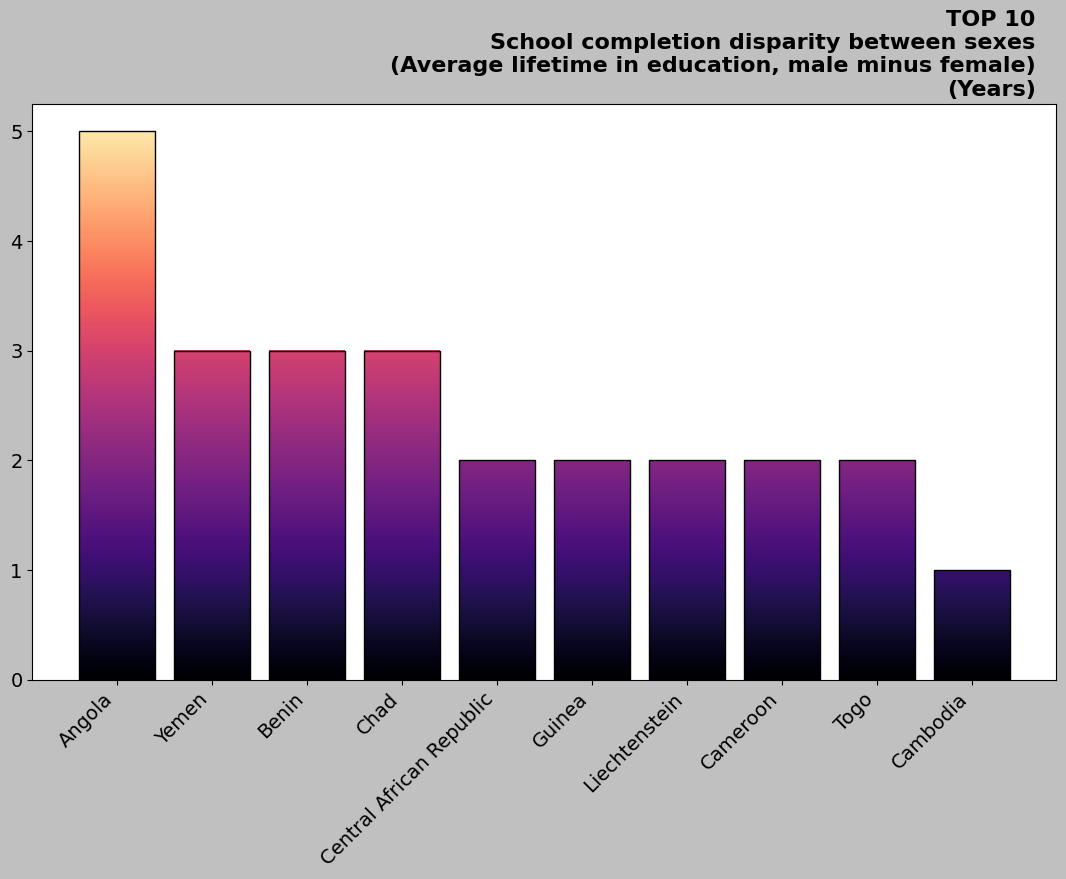

In [25]:
nData.DF[ (ft := 'School completion disparity between sexes') ] = (
    nData.DF[ f'{lifexpFt} male' ] - nData.DF[ f'{lifexpFt} female' ])

showMax( ft, unit='(Years)',
    sub="Average lifetime in education, male minus female" )


<hr style="height:2px;background-color:gray">

- Most **emmigration** (highest net-negative migration), and **populations in 
greatest contraction** (negative pop growth): two very strong categories occur -
either islands (esp. Pacific), or eastern Europe. Syria and South Sudan, on the 
other hand, are booming.

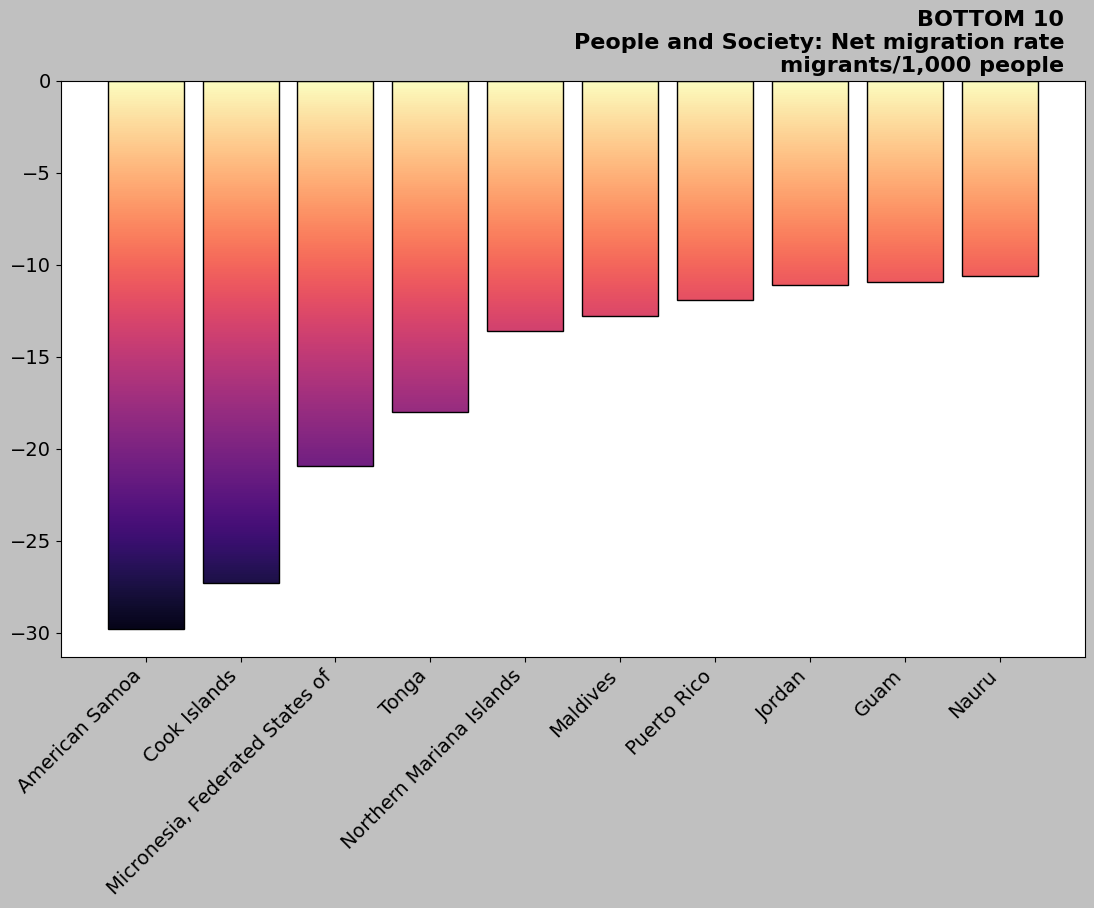

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
People and Society: Net migration rate


,ctry_i,ctry_s,zScore,value,orVal
197,224,Syria,6.695,40.580,"40.58 migrant(s)/1,000 population (2022 est.) NA"
189,215,South Sudan,3.501,20.970,"20.97 migrant(s)/1,000 population (2022 est.)"
205,232,Tonga,-2.847,-18.010,"-18.01 migrant(s)/1,000 population (2022 est.)"
131,151,"Micronesia, Federated States of",-3.320,-20.910,"-20.91 migrant(s)/1,000 population (2022 est.)"
46,55,Cook Islands,-4.362,-27.310,"-27.31 migrant(s)/1,000 population (2022 est.)"
2,3,American Samoa,-4.768,-29.800,"-29.8 migrant(s)/1,000 population (2022 est.)"


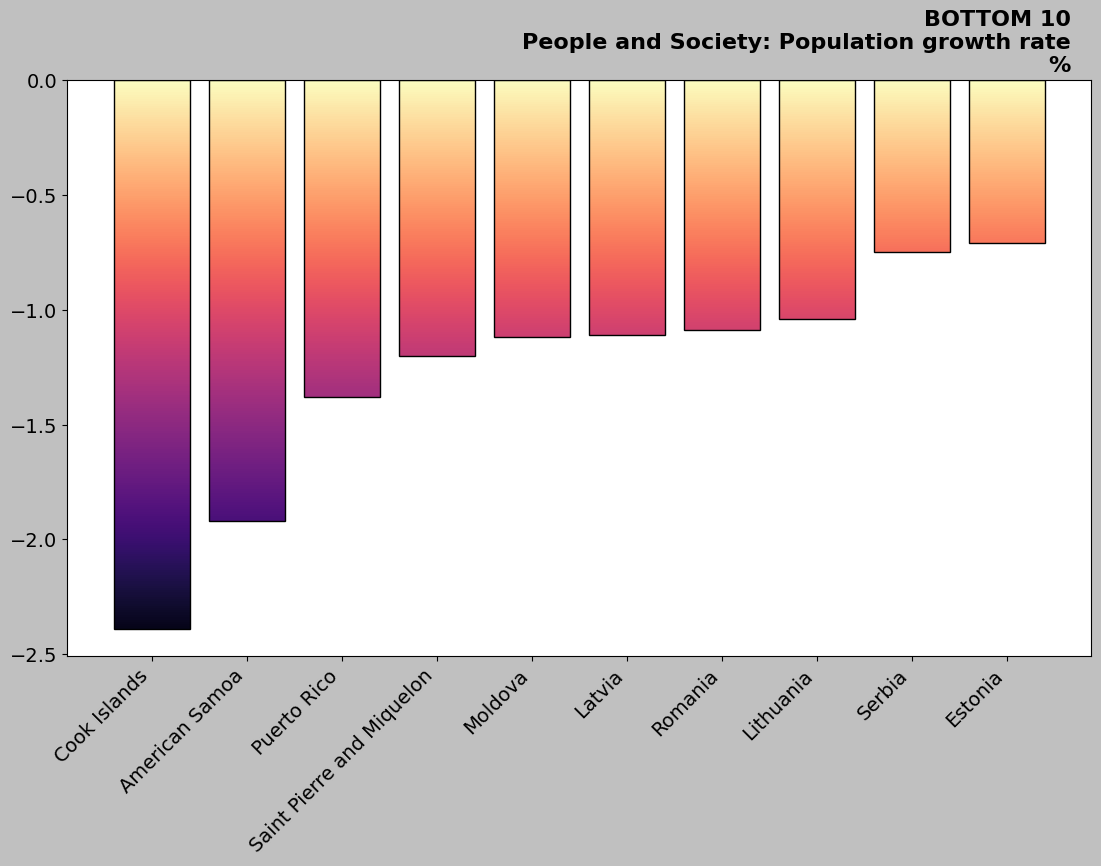

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
People and Society: Population growth rate


,ctry_i,ctry_s,zScore,value,orVal
204,224,Syria,4.439,5.910,5.91% (2022 est.)
196,215,South Sudan,3.547,4.910,4.91% (2022 est.)
2,3,American Samoa,-2.547,-1.920,-1.92% (2022 est.)
48,55,Cook Islands,-2.966,-2.390,-2.39% (2022 est.)


In [26]:
showMax( 'People and Society: Net migration rate', asc=True )
zThresh( 'People and Society: Net migration rate', 2.5 )
showMax( 'People and Society: Population growth rate', asc=True )
zThresh( 'People and Society: Population growth rate', 2.5 )

***
#### *COAL, ENERGY AND POLLUTION*

- **Not a glitch:** this is what the top-ten coal producers and consumers look 
like:

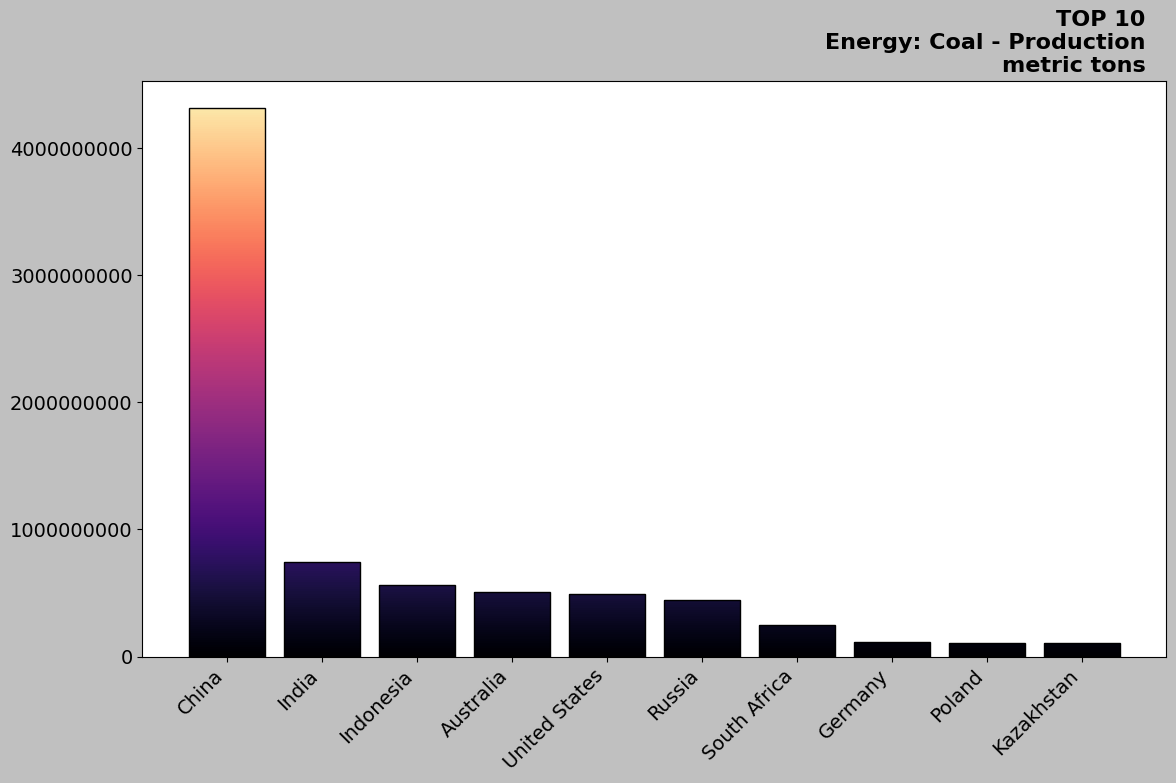

Z_SCORES OUTSIDE >+/<-[ 2 ] for non-NaNs in:
Energy: Coal - Production


,ctry_i,ctry_s,zScore,value,orVal
40,47,China,13.894,4314681000.000,"4,314,681,000 metric tons (2020 est.)"
88,107,India,2.288,743214000.000,743.214 million metric tons (2020 est.)


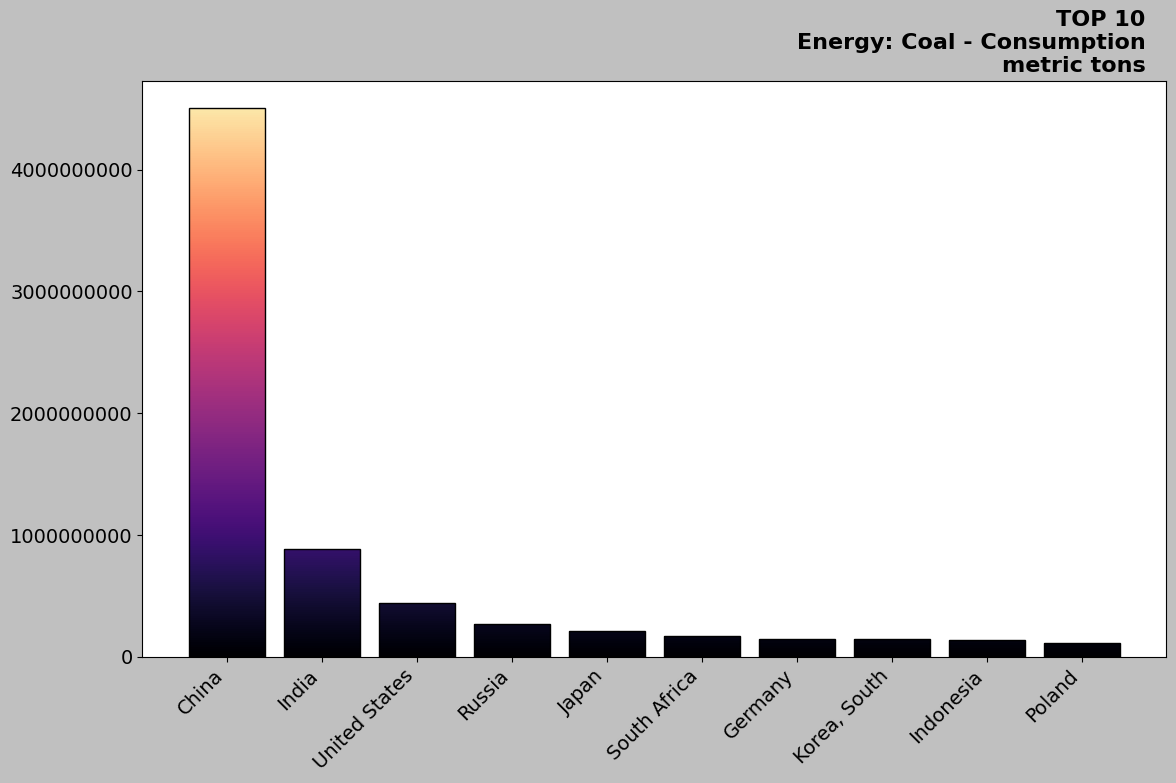

Z_SCORES OUTSIDE >+/<-[ 2 ] for non-NaNs in:
Energy: Coal - Consumption


,ctry_i,ctry_s,zScore,value,orVal
40,47,China,14.082,4506387000.000,"4,506,387,000 metric tons (2020 est.)"
88,107,India,2.666,883979000.000,883.979 million metric tons (2020 est.)


In [27]:
product = 'Energy: Coal - Production'
consump = 'Energy: Coal - Consumption'
exports = 'Energy: Coal - Exports'
imports = 'Energy: Coal - Imports'

showMax( product )
zThresh( product, 2, )
showMax( consump )
zThresh( consump, 2, )

- For both **Coal production and consumption**, The only nation falling outside 
three standard deviations of the mean, falls outside by around ***fourteen*** 
standard deviations. More astonishingly, China remains a net importer - they 
consume this and more.

In [28]:
chinaProd = nData.DF[ nData.DF.Country == 'China' ][ product ].sum()
chinaCsmp = nData.DF[ nData.DF.Country == 'China' ][ consump ].sum()

notChinaProd = nData.DF[ nData.DF.Country != 'China' ][ product ].sum()
notChinaCsmp = nData.DF[ nData.DF.Country != 'China' ][ consump ].sum()

# get longest string length to pad report field
pad = (max( [ len( str( i ) )
    for i in [ chinaProd, notChinaProd, chinaCsmp, notChinaCsmp ] ] ))

print( f"PRODUCTION: China's production is "
       f"[ {(chinaProd / notChinaProd):,.2f} ] times the rest of world's:\n"
       f"   [ {chinaProd:>{pad},.2f} ]: China's coal production\n"
       f"   [ {notChinaProd:>{pad},.2f} ]: rest of world combined\n" )
print( f"CONSUMPTION: China's consumption is "
       f"[ {(chinaCsmp / notChinaCsmp):,.2f} ] times the rest of world's:\n"
       f"   [ {chinaCsmp:>{pad},.2f} ]: China's coal consumption\n"
       f"   [ {notChinaCsmp:>{pad},.2f} ]: rest of world combined\n" )

PRODUCTION: China's production is [ 1.09 ] times the rest of world's:
   [ 4,314,681,000.00 ]: China's coal production
   [ 3,972,154,000.00 ]: rest of world combined

CONSUMPTION: China's consumption is [ 1.28 ] times the rest of world's:
   [ 4,506,387,000.00 ]: China's coal consumption
   [ 3,532,889,000.00 ]: rest of world combined



<hr style="height:2px;background-color:gray">

- We can get an image of a country's **relationship with coal** if we look at 
the combined production and imports in ratio to exports. Where this ratio is 
above one, a country has exported above the total produced and imported, meaning 
it has sold reserves. Refining further to only the countries whose coal exports 
are above the world-mean, we can see who has a strong reliance on coal exports. 
</br> </br> In order, the refinement exludes Venezuela, Belarus and Eswatini 
such that Russia, South Africa and the Phillipines enter the **top sellers**

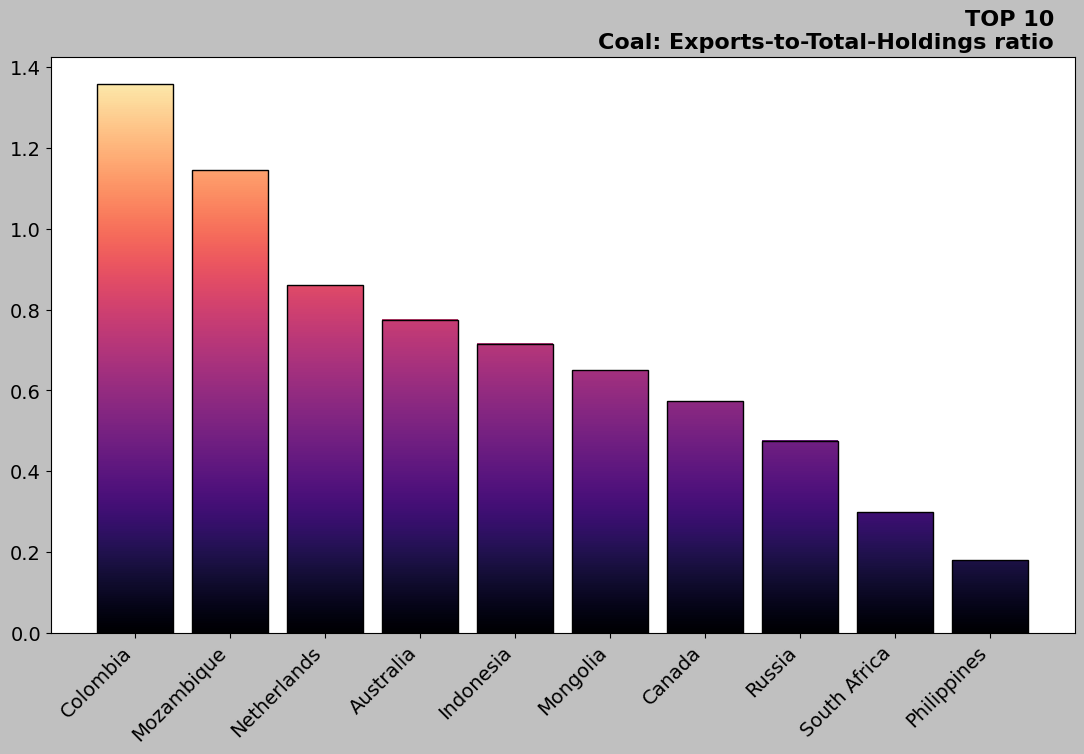

In [29]:
nData.DF[ 'Coal: Exports-to-Total-Holdings ratio' ] = (
    nData.DF[ exports ] / (nData.DF[ product ] + nData.DF[ imports ]))

aboveMeans = [ country for country in nData.DF[ 'Country' ] if (
    nData.DF.loc[ nData.DF[ 'Country' ] == country, exports ].iloc[ 0 ]
    >= nData.DF[ exports ].mean()) ]

showMax( 'Coal: Exports-to-Total-Holdings ratio',
    mask=nData.DF[ 'Country' ].isin( aboveMeans ), unit="_" )

<hr style="height:2px;background-color:gray">

- Naturally, on the topic of coal, a look at the **Dirtiest consumers** (hi 
there Australia!) 
    

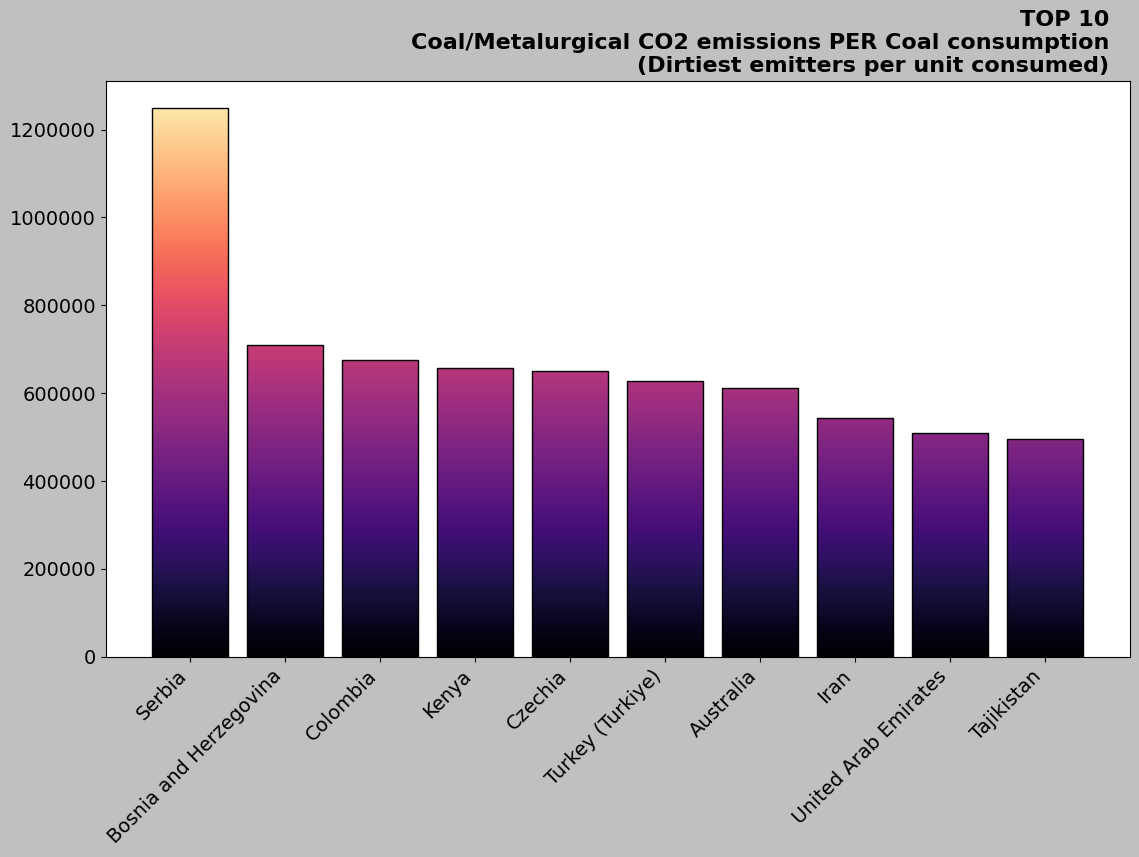

In [30]:
emissns = 'Energy: Carbon dioxide emissions - From coal and metallurgical coke'

nData.DF[ 'Coal/Metalurgical CO2 emissions PER Coal consumption' ] = (
    nData.DF[ consump ] / nData.DF[ emissns ])

showMax( 'Coal/Metalurgical CO2 emissions PER Coal consumption',
    sub='Dirtiest emitters per unit consumed', unit="_" )

<hr style="height:2px;background-color:gray">

- Kenya's **Geothermal energy mix** is impressive. Good geology: </br> </br>
>In places where tectonic plates – consisting of the Earth's crust, and the 
upper mantle – are being pushed together or torn apart, this heat rises closer 
to the surface. One such place is Africa's Great Rift Valley, which runs 
7,000km (4,350 miles) across the eastern side of the continent.
> *(Source: 
> [BBC](https://www.bbc.com/future/article/20210303-geothermal-the-immense-volcanic-power-beneath-our-feet))*

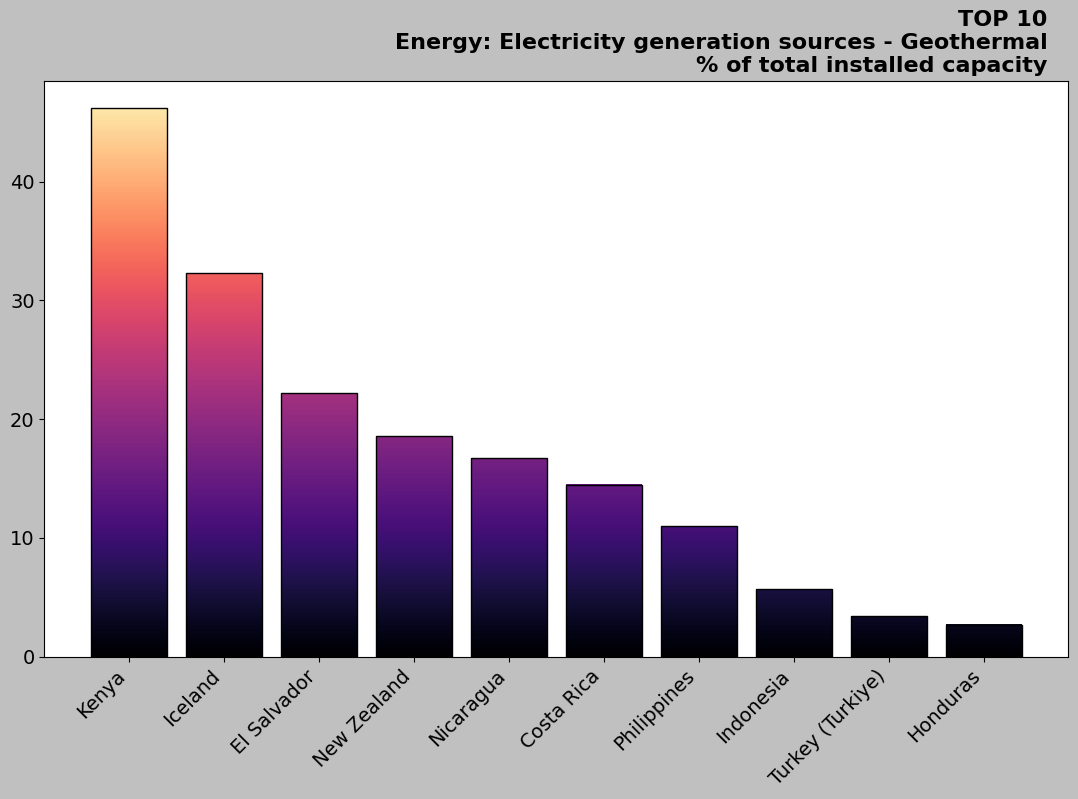

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Energy: Electricity generation sources - Geothermal


,ctry_i,ctry_s,zScore,value,orVal
99,123,Kenya,9.733,46.200,46.2% of total installed capacity (2020 est.)
87,106,Iceland,6.749,32.300,32.3% of total installed capacity (2020 est.)
56,70,El Salvador,4.580,22.200,22.2% of total installed capacity (2020 est.)
135,166,New Zealand,3.807,18.600,18.6% of total installed capacity (2020 est.)
136,167,Nicaragua,3.399,16.700,16.7% of total installed capacity (2020 est.)
45,57,Costa Rica,2.927,14.500,14.5% of total installed capacity (2020 est.)


In [31]:
ft = 'Energy: Electricity generation sources - Geothermal'
showMax( ft )
zThresh( ft, 2.5 )

***
#### *ECONOMY*
- If you tend to assume that countries usually **spend close to what they make 
in revenue**, take confidence from seeing how both rise together in very close 
proportion - **almost a perfect correlation of 0.997**

LIN. CORR: 0.9970406963639609 for
    Economy: Budget - revenues
    and Economy: Budget - expenditures

Feats: [ Economy: Budget - revenues ]
       [ Economy: Budget - expenditures ]


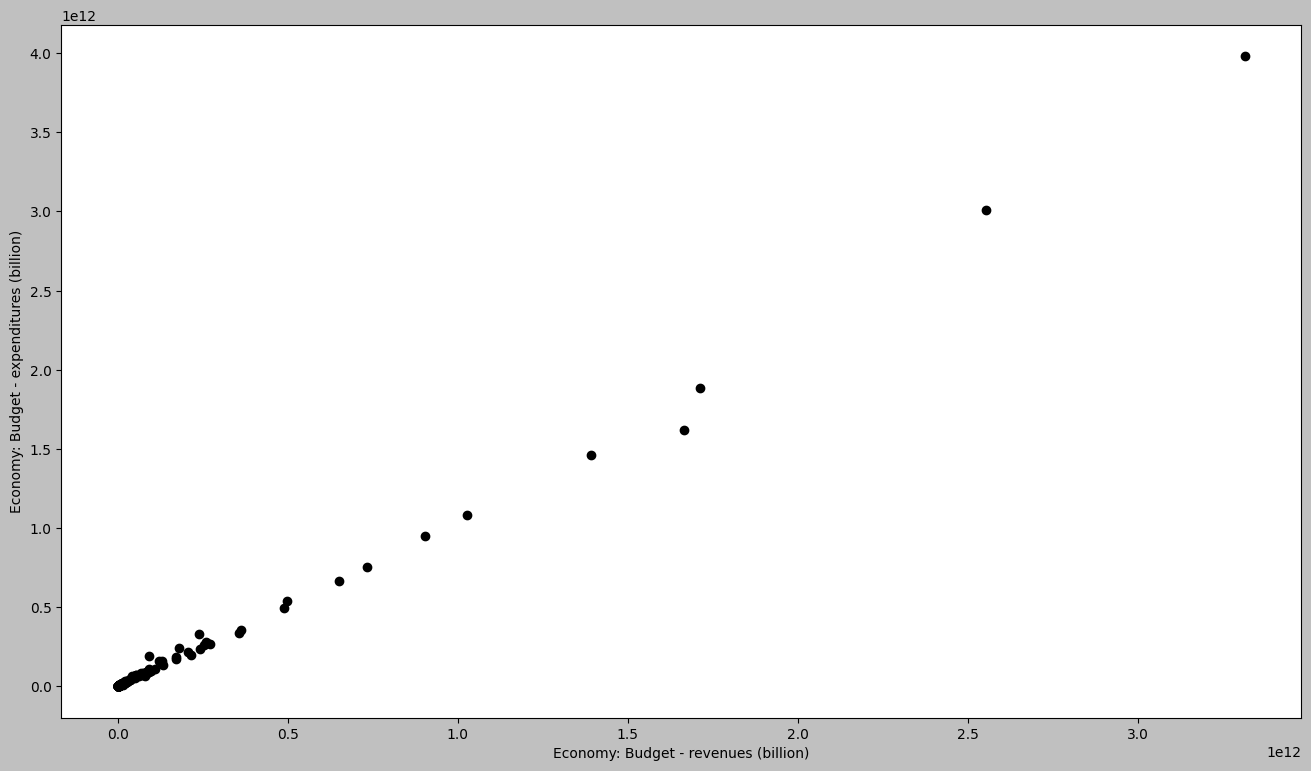

In [32]:
x, y = 'Economy: Budget - revenues', 'Economy: Budget - expenditures'
print( f"{dUtls.reportCorr( [ x, y ] )} for\n    {x}\n    and {y}\n" )

pltSctr( [ 'Economy: Budget - revenues', 'Economy: Budget - expenditures' ] )

- **Services share of GDP**: which sovereignties pay the bills almost entirely 
from desk-work?

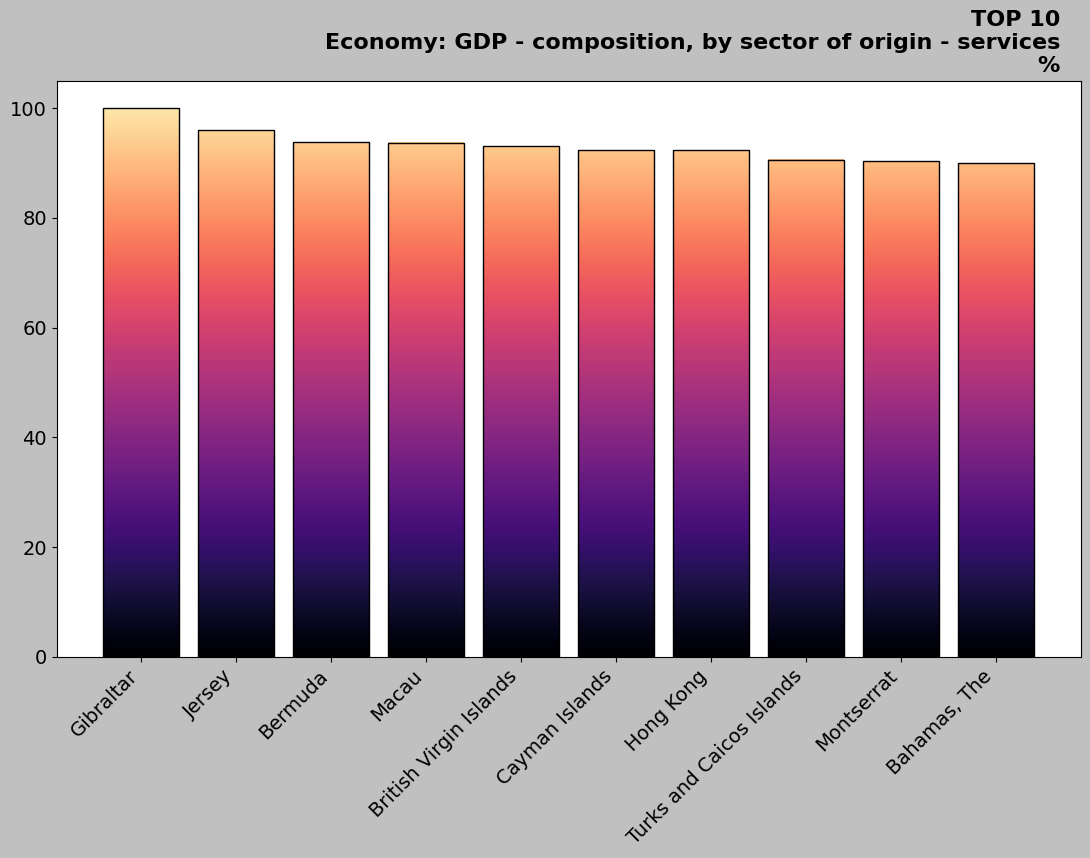

In [33]:
showMax( 'Economy: GDP - composition, by sector of origin - services' )

<hr style="height:2px;background-color:gray">

- **Inflation**: Venezuela dwarfs the world at *fifteen* times the standard 
deviation.

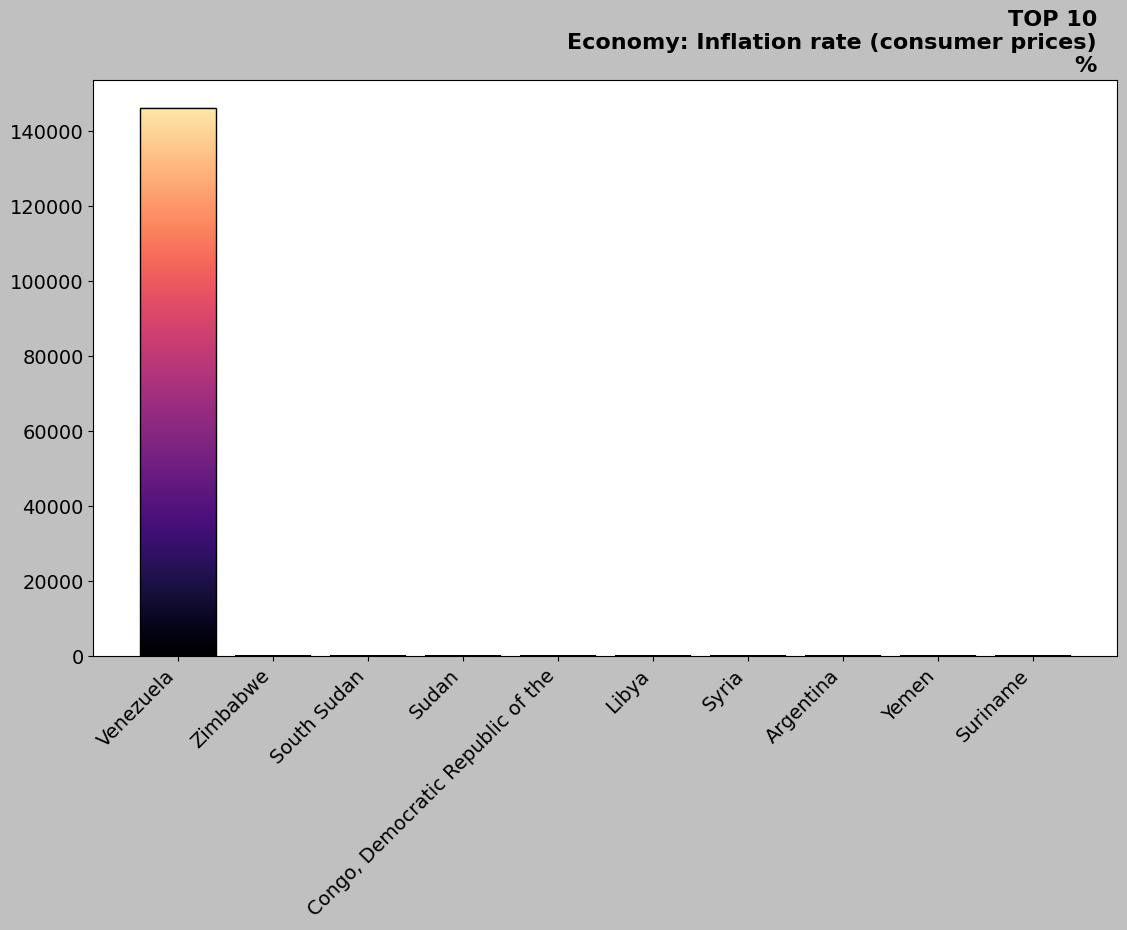

Z_SCORES OUTSIDE >+/<-[ 0.0677 ] for non-NaNs in:
Economy: Inflation rate (consumer prices)


,ctry_i,ctry_s,zScore,value,orVal
217,247,Venezuela,14.967,146101.700,"146,101.7% (2019 est.)45,518.1% (2018 est.)416..."
30,36,Burkina Faso,-0.068,-3.200,-3.2% (2019 est.)1.9% (2018 est.)1.4% (2017 est.)


In [34]:
showMax( ft := 'Economy: Inflation rate (consumer prices)' )
zThresh( ft, 0.0677 )

<hr style="height:2px;background-color:gray">

- **Robot Ranchers**: who are the **most efficient farmers**? 

In [35]:
# # Error in the scraped data for Tonga (date taken as percent).
# set country value for feature to (feature without country obs) mean
dUtls.setMean( ft, "Tonga", [ nData.DF, nData.NU ] )

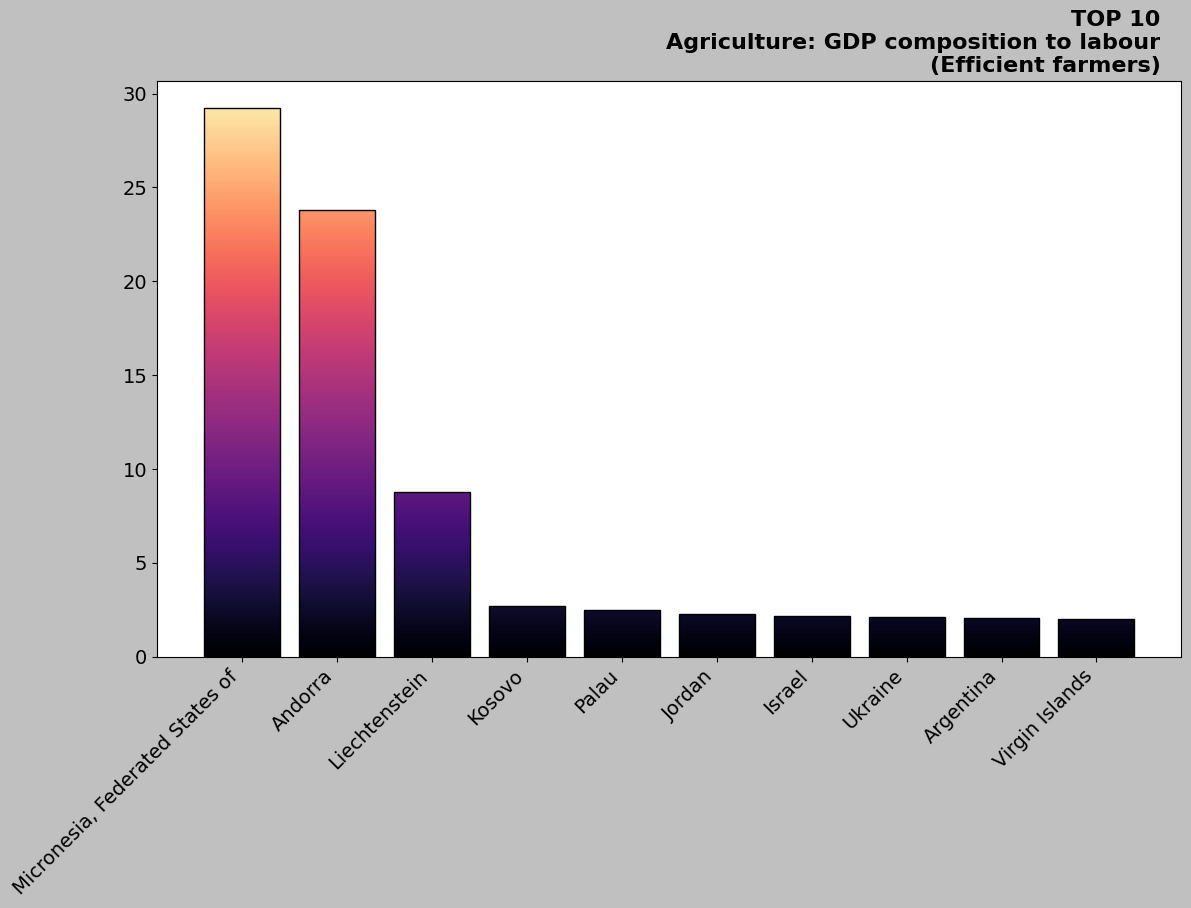

In [36]:
nData.DF[ 'Agriculture: GDP composition to labour' ] = (
    nData.DF[ 'Economy: GDP - composition, by sector of origin - agriculture' ]
    / nData.DF[ 'Economy: Labor force - by occupation - agriculture' ])

showMax( 'Agriculture: GDP composition to labour', unit="_",
    mask=nData.DF[ 'Country' ] != "Tonga", sub="Efficient farmers" )

<hr style="height:2px;background-color:gray">

- One last item on *Economy*: Maldives' **goods and services importation** is 
uniquely astronomical.

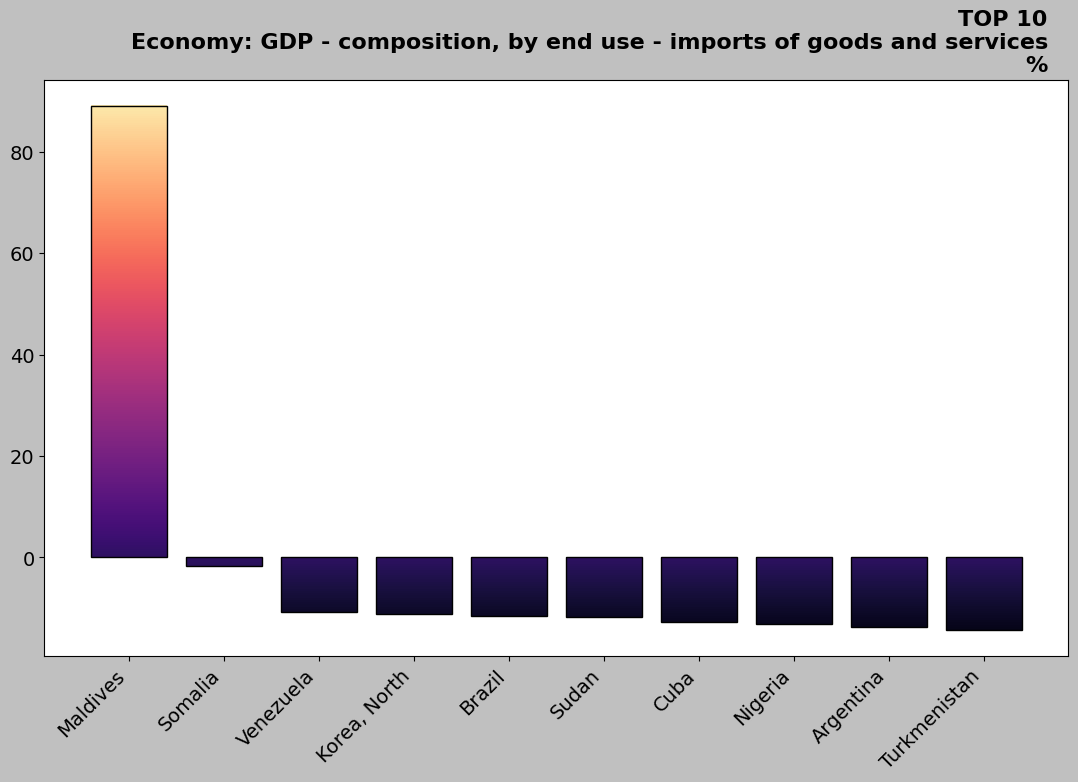

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Economy: GDP - composition, by end use - imports of goods and services


,ctry_i,ctry_s,zScore,value,orVal
115,144,Maldives,4.758,89.000,89% (2016 est.)
151,188,Puerto Rico,-2.808,-129.800,-129.8% (2017 est.)
167,208,Singapore,-3.476,-149.100,-149.1% (2017 est.)
160,201,San Marino,-3.621,-153.300,-153.3% (2011)
83,103,Hong Kong,-4.790,-187.100,-187.1% (2017 est.)
110,139,Luxembourg,-5.029,-194.000,-194% (2017 est.)


In [37]:
# gdp-by-imports: maldives only positive, and vastly so [...]
ft = 'Economy: GDP - composition, by end use - imports of goods and services'
showMax( ft )
zThresh( ft, 2.5 )

***
#### *GEOGRAPHY AND ENVIRONMENT*

- **Most watery nations** ( total area by surface water )

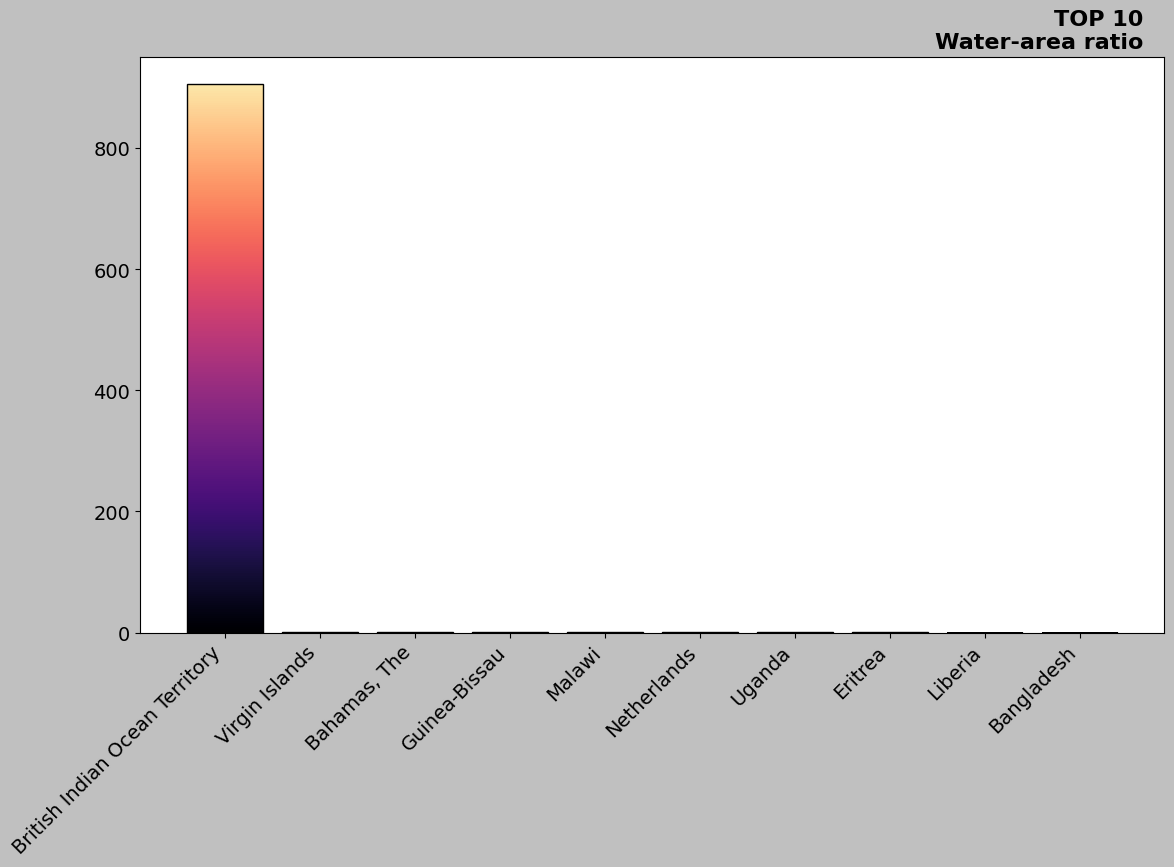

In [38]:
# highest percent water area
nData.DF[ 'Water-area ratio' ] = (
    nData.DF[ 'Geography: Area - water' ] /
    nData.DF[ 'Geography: Area - total' ])
showMax( 'Water-area ratio', unit="_" )

The British Indian Ocean Territory value here is an outlier arising from its
the water-area being recorded as considerably larger than the total area, 
which purports to include both water and land. For those understandably 
unfamiliar with the territory, it is designated across a rather isloated 
archipelago in a geographically significant position. Some interesting reading 
for both  observers of colonialism and of ongoing events in the projection of 
sovereign power across large sea vectors:

##### British Indian Ocean Territory
![British_Indian_Ocean_Territory](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/British_Indian_Ocean_Territory_in_United_Kingdom.svg/1466px-British_Indian_Ocean_Territory_in_United_Kingdom.svg.png)

WIKI: 
>The only inhabitants are British and U.S. military personnel and associated 
contractors, who collectively number around 3,000 (2018 figures). The forced 
removal of Chagossians from the Chagos Archipelago occurred between 1968-1973. 
Today, the exiled Chagossians are still trying to return, saying that the 
forced expulsion and dispossession was unlawful, but the UK government has 
repeatedly denied them the right of return. The islands are off-limits to 
Chagossians, casual tourists, and the media.

- **Excluding the BIOT as an outlier** should reveal a more intuitive 
distribution. Better yet, to avoid catching so many islands, let's filter down 
to countries whose coastline is no longer than their land boundaries with other 
countries.

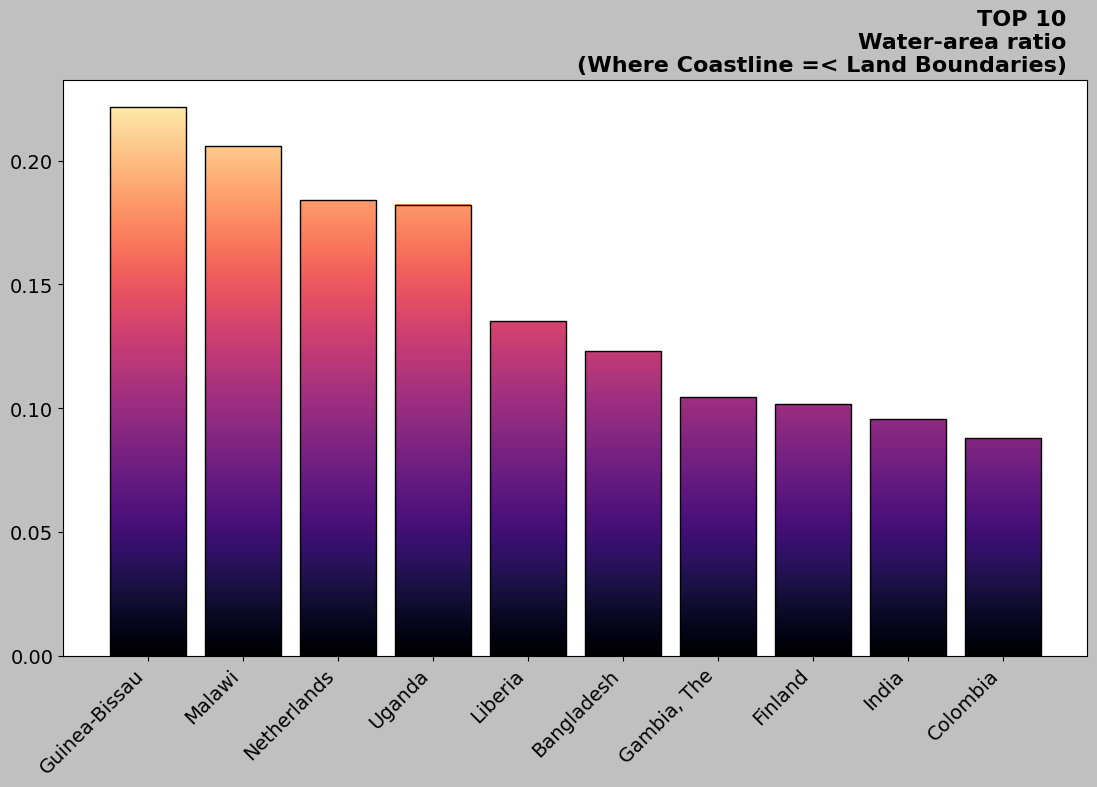

In [39]:
showMax( 'Water-area ratio', unit="_", sub="Where Coastline =< Land Boundaries",
    mask=nData.DF[ 'Geography: Land boundaries - total' ] >=
         nData.DF[ 'Geography: Coastline' ] )

<hr style="height:2px;background-color:gray">

- **Elevation difference**: Countries with the largest difference between their 
lowest and highest point. While the China-Nepal border equally dissects 
Siggamartha's (Everest's) highest point, China itself has a lower minimum 
elevation than Nepal.

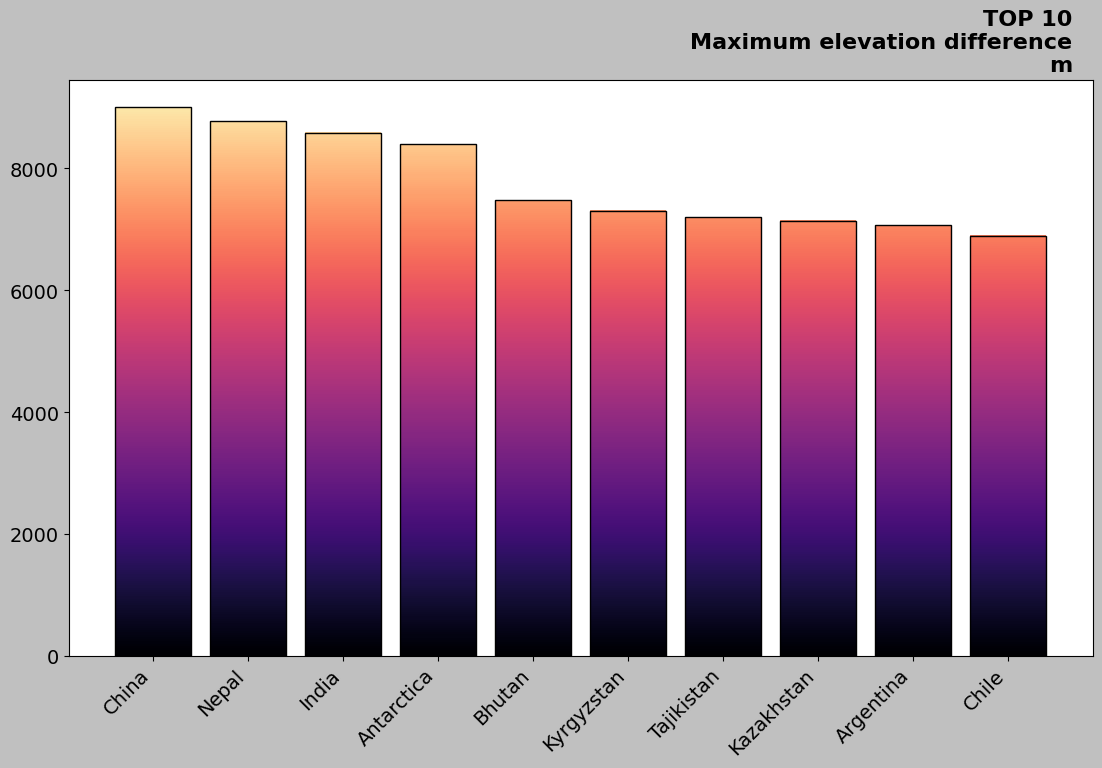

In [40]:
nData.DF[ 'Maximum elevation difference' ] = (
    nData.DF[ 'Geography: Elevation - highest point' ] -
    nData.DF[ 'Geography: Elevation - lowest point' ])

showMax( 'Maximum elevation difference', unit="m" )

- **Flattest places in the world**: no point on natural ground is at an ascent 
of more of than five meters from any other point. At #4 in the world, Pakistan's 
current floods are devastating partly due to this marked flatness. </br> </br> 
Cayman Islands is easiest on the hips with a M.E.D of one meter.

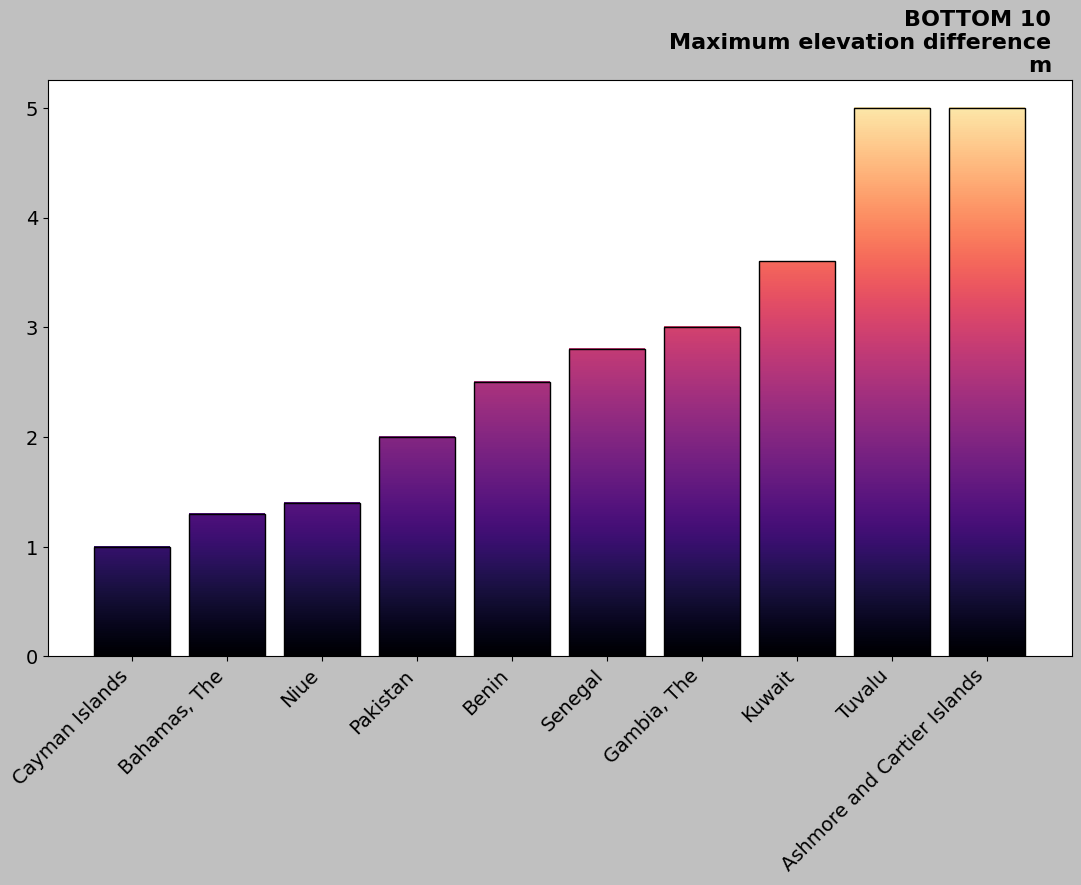

In [41]:
showMax( 'Maximum elevation difference', asc=True, unit="m" )

<hr style="height:2px;background-color:gray">

- **Water withdrawrals minus renewable sources**: Who are the most- and least- 
reliant on trade for water? 

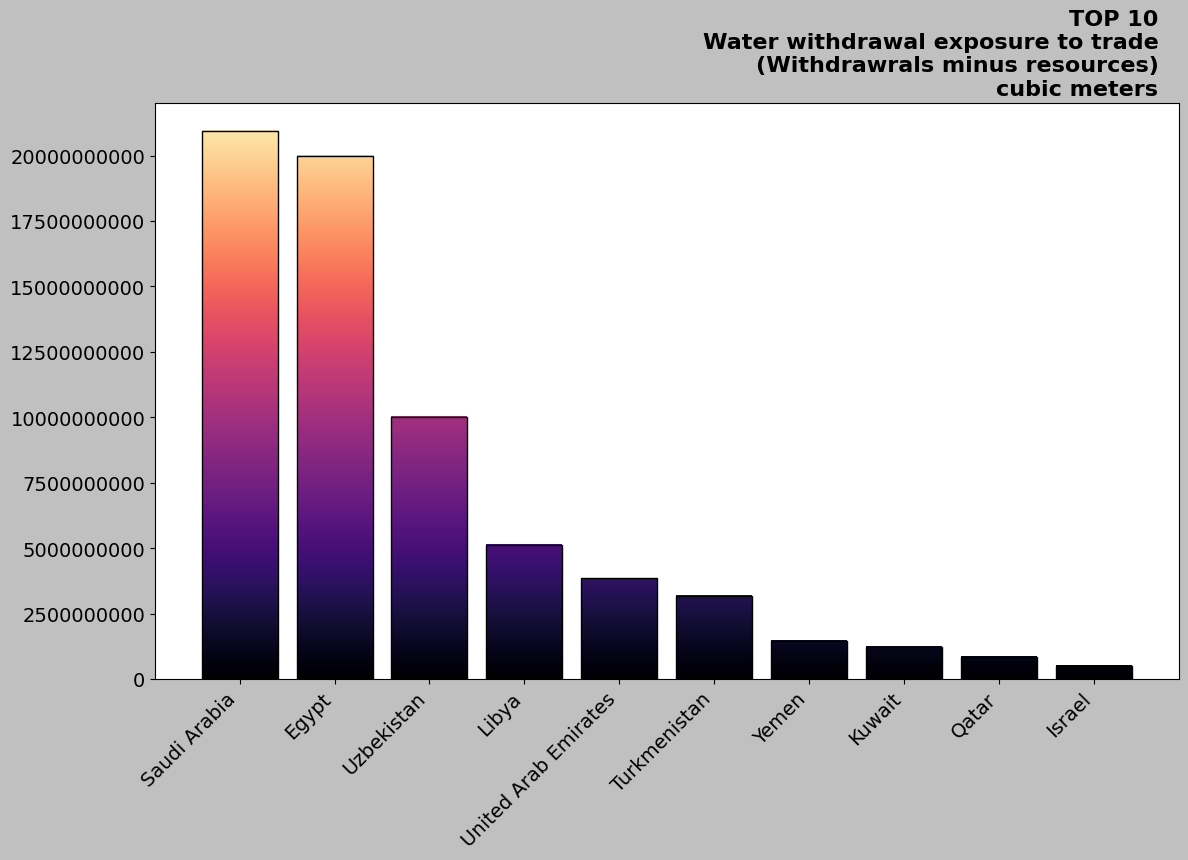

In [42]:
nData.DF[ 'Water withdrawal exposure to trade' ] = (
    (nData.DF[ 'Environment: Total water withdrawal - municipal' ] +
     nData.DF[ 'Environment: Total water withdrawal - industrial' ] +
     nData.DF[ 'Environment: Total water withdrawal - agricultural' ]) -
    nData.DF[ 'Environment: Total renewable water resources' ])

showMax( 'Water withdrawal exposure to trade',
    sub="Withdrawrals minus resources", unit="cubic meters" )

- **Most trade-exposed**: Hi there, Middle East! **Least**: Brazil is sitting 
happy there around the Amazon, while Russia and Canada just hold a cup against 
a nearby melting glacier.

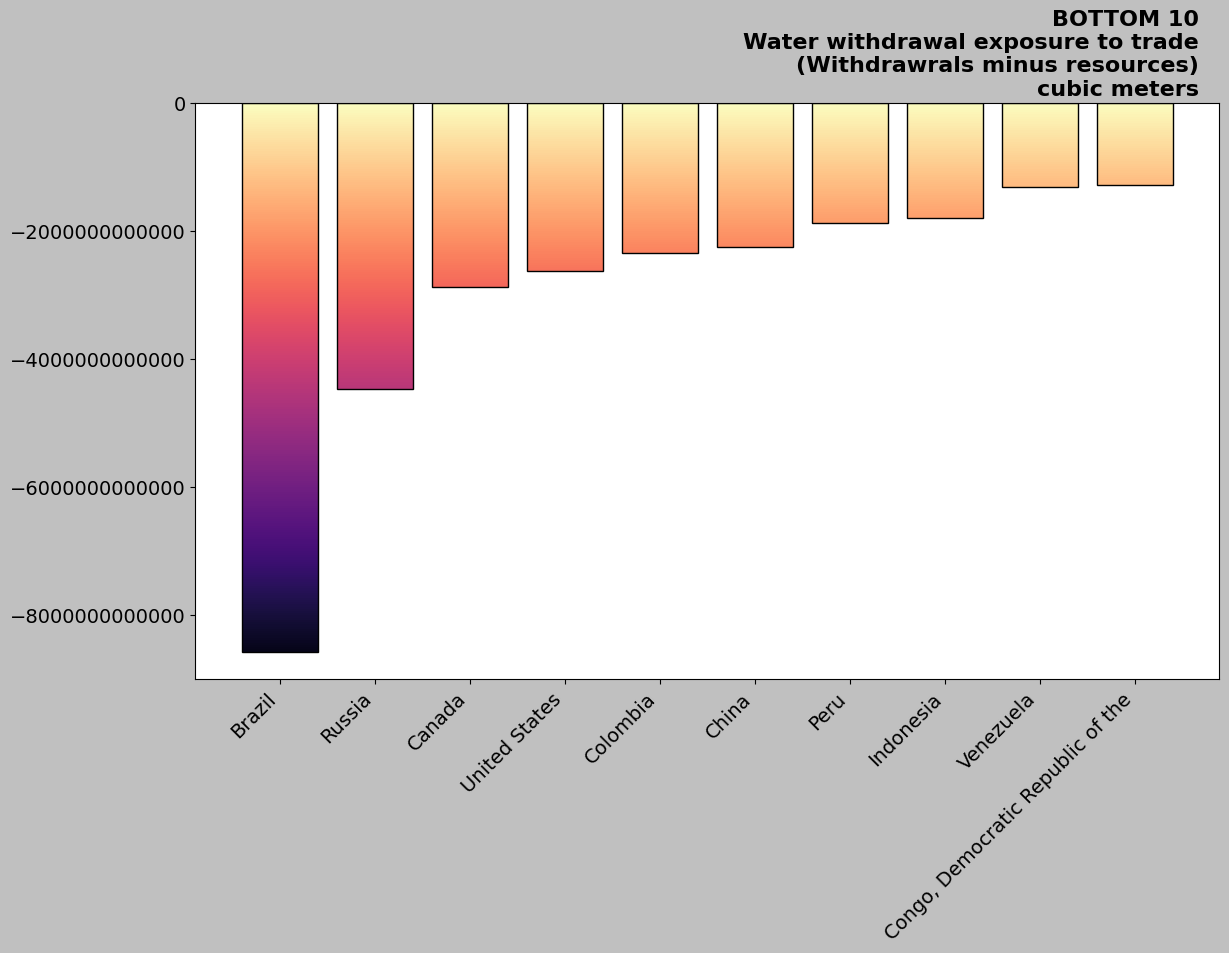

In [43]:
showMax( 'Water withdrawal exposure to trade', asc=True, unit="cubic meters",
    sub="Withdrawrals minus resources" )

<hr style="height:2px;background-color:gray">

- **Irrigated area ratio:** Many members of this T10 may not surprise, as 
familiar origins of agricultural commodities, but the Gaza Strip may conjure a 
more arid image.

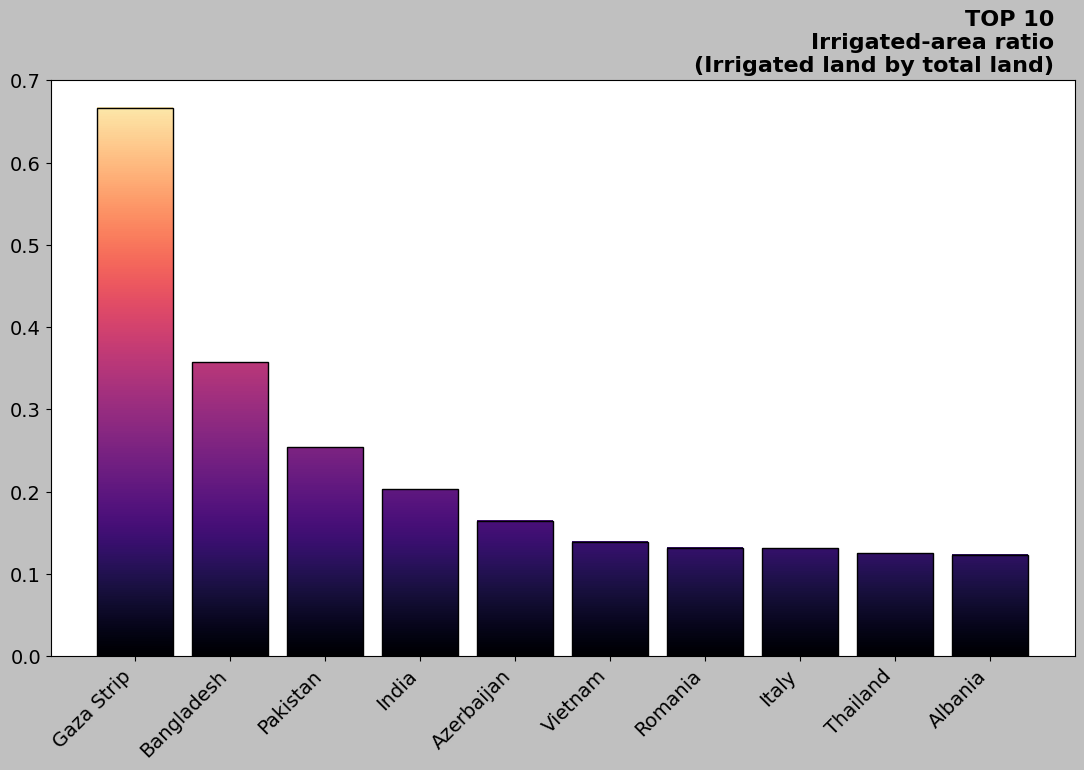

Irrigated area in Gaza Strip is 240.0 sqkm
Total area of Gaza Strip is 360.0 sqkm


In [44]:
# Ratio of irrigated land to total land

nData.DF[ 'Irrigated-area ratio' ] = (
    nData.DF[ 'Geography: Irrigated land' ] /
    nData.DF[ 'Geography: Area - total' ])

showMax( 'Irrigated-area ratio', sub="Irrigated land by total land", unit="_" )

print( f"Irrigated area in Gaza Strip is "
       f"{getVal( 'Gaza Strip', 'Geography: Irrigated land' )} sqkm" )

print( f"Total area of Gaza Strip is "
       f"{getVal( 'Gaza Strip', 'Geography: Area - total' )} sqkm" )

The value comes down to proportion, of course (irrigation takes up 240 of the 
territory's 360 square kilometers), but more deeply to demographics. The Gaza 
Strip is the third-most densely populated territory in the world, and has a 
special reliance on agricultre as a 
[vital element of food production and employment](https://socialsciences.mcmaster.ca/kubursi/ebooks/water.htm).

***
Thanks for the read! Check for more analysis and other projects at 
**[github.com/romstroller](https://github.com/romstroller/)**